#### Test whether using only excitatory firing rates in decomposition can help

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os, sys
from glob import glob
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import gaussian_filter
import h5py
import quantities as pq

sys.path.append('../scripts/')
from LPA import LPA_Signal

sys.path.append('../scripts/icsd_scripts/')
from data_processing_before_lpa import *

%config Completer.use_jedi = False

In [3]:
sim_data_dir = '/Users/atleeskelandrimehaug/Dropbox (Simula)/Data/output_sims'
fig_dir = 'Figures/for_meeting_w_Gaute_April_14'

In [4]:
# for plotting
plt.rcParams.update({'font.size': 16})

## Load simulation data

In [5]:
nchan_sim = 26                                          # Number of channels on probe in simulation

trial_dur_sim = 750                                     # Duration one trial (ms)
tstim_onset_sim = 250
tstim_onset_sim_dg = 500
trial_dur_sim_dg = 3000
ntrials_sim = 10                                        # Number of trials
t_rem_trial_start = 50

trial_dur_sim_corr = trial_dur_sim-t_rem_trial_start
trial_dur_sim_dg_corr = 3000-t_rem_trial_start
tstim_onset_sim = tstim_onset_sim-t_rem_trial_start
tstim_onset_sim_dg = tstim_onset_sim_dg-t_rem_trial_start

channel = np.arange(nchan_sim)

### MUA

In [6]:
mua_sims_all_stim = dict()

#### Flashes

In [7]:
sim_data_dir = '/Users/atleeskelandrimehaug/Dropbox (Simula)/Data/output_sims'

#selected_sims_data_dir = os.path.join(sim_data_dir, '2021', 'jan', '2022_jan_07*')

selected_sims_data_dir = os.path.join(sim_data_dir, '2023', 'flash', 'apr', '*shift*')

#mua_sims = find_files(selected_sims_data_dir, filename = 'mua.npy')

mua_sims = find_files(selected_sims_data_dir, filename = 'mua_w_baseline.npy')

for sim_name in list(mua_sims.keys()):
    if 'jan_07' not in sim_name or 'fb_to_L1' in sim_name or 'w_20um' in sim_name:# or 'black' in sim_name:
        del mua_sims[sim_name]
        
if len(mua_sims.keys()) == 1:
    sim_name = list(mua_sims.keys())[0]
elif len(mua_sims.keys()) > 1:
    sim_names = list(mua_sims.keys())
    sim_name = sim_names[0]
print(mua_sims.keys())

for sim_name in list(mua_sims.keys())[::-1]:
    mua_sims_all_stim[sim_name] = mua_sims[sim_name]
    print(sim_name)

dict_keys(['2022_jan_07_black_shift', '2022_jan_07_shift'])
2022_jan_07_shift
2022_jan_07_black_shift


#### Natural scenes

#### Gabors

#### Drifting gratings

### Splice

In [8]:
(len(mua_sims_all_stim.keys()),)

(2,)

In [9]:
nchan_lim = 22

In [10]:
mua_sims_trial_avg = np.zeros((len(mua_sims_all_stim.keys()), nchan_lim, mua_sims_all_stim[sim_name]['trial_avg'].shape[1]))

for isim, sim_name in enumerate(mua_sims_all_stim.keys()):
    print(sim_name)
    mua_sims_trial_avg[isim] = mua_sims_all_stim[sim_name]['trial_avg'][:nchan_lim]

2022_jan_07_shift
2022_jan_07_black_shift


In [11]:
mua_sims_trial_avg[isim].shape

(22, 700)

In [59]:
mua_sims_trial_avg.shape

(2, 22, 700)

In [12]:
nchan_lim*40

880

In [13]:
mua_sims_all_trials = np.zeros((len(mua_sims_all_stim.keys()), mua_sims_all_stim[sim_name]['all_trials'].shape[0], 
                               nchan_lim, mua_sims_all_stim[sim_name]['all_trials'].shape[-1]))

for isim, sim_name in enumerate(mua_sims_all_stim.keys()):
    print(sim_name)
    mua_sims_all_trials[isim][:,:nchan_lim] = mua_sims_all_stim[sim_name]['all_trials'][:,:nchan_lim]

2022_jan_07_shift
2022_jan_07_black_shift


In [14]:
np.shape(mua_sims_all_trials)

(2, 10, 22, 700)

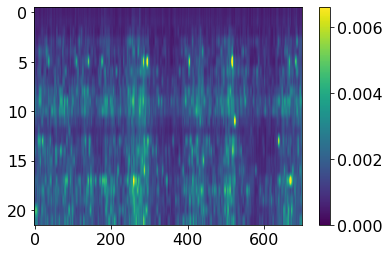

In [15]:
mua_plot = mua_sims_trial_avg[0]
cmap_range= np.abs(mua_plot).max()/2
plt.imshow(mua_plot, aspect = 'auto', vmin = 0, vmax = cmap_range)
plt.colorbar()

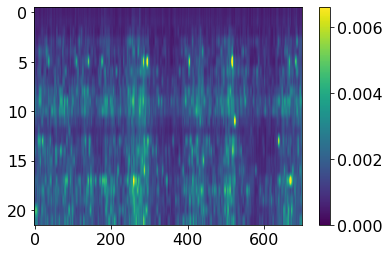

In [16]:
mua_plot = mua_sims_trial_avg[0]
cmap_range= np.abs(mua_plot).max()/2
plt.imshow(mua_plot, aspect = 'auto', vmin = 0, vmax = cmap_range)
plt.colorbar()

In [17]:
mua_sims_trial_avg.shape

(2, 22, 700)

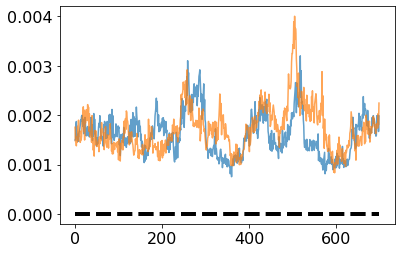

In [18]:
for istim in range(mua_sims_trial_avg.shape[0]):
    mua_plot = mua_sims_trial_avg[istim]
    plt.plot(np.mean(mua_plot, axis = 0), alpha = 0.7)
    plt.hlines(y = 0, xmin = 0, xmax = 700, ls = '--', lw = 4)

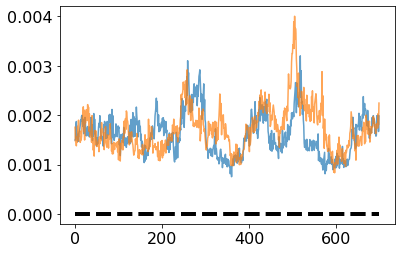

In [19]:
for istim in range(mua_sims_trial_avg.shape[0]):
    mua_plot = mua_sims_trial_avg[istim]
    plt.plot(np.mean(mua_plot, axis = 0), alpha = 0.7)
    plt.hlines(y = 0, xmin = 0, xmax = 700, ls = '--', lw = 4)

### Spikes

- Load population spike trains from sims with different stimuli

In [20]:
timestamps_all_stim = dict()

#### Flashes

In [21]:
#path = os.path.join(sim_data_dir,'2021', 'nov')
path = os.path.join(sim_data_dir,'2021', 'jan')

#big_and_small_pup_data_dir_selected_sims = os.path.join(sim_data_dir, 'big_and_small_pup_trials', '2021', 'week_27', '2021_july_06_small_pup')

timestamps_configs = find_all_fir_rates_files_sim(path, 'timestamps_with_neuron_ids*.npy')
sim_names = list(timestamps_configs.keys())
print(sim_names)
sim_name = sim_names[-1]

['2022_jan_07', '2022_jan_06', '2022_jan_03', '2022_jan_05', '2022_jan_07_w_fb_to_L1_conns', '2022_jan_07_black']


In [22]:
for sim_name in list(timestamps_configs.keys()):
    if 'jan_07' not in sim_name or 'w_fb_to_L1' in sim_name:# or 'black' in sim_name:
        del timestamps_configs[sim_name]
        
if len(timestamps_configs.keys()) == 1:
    sim_name = list(timestamps_configs.keys())[0]
elif len(timestamps_configs.keys()) > 1:
    sim_names = list(timestamps_configs.keys())
    sim_name = sim_names[0]
timestamps_configs.keys()

dict_keys(['2022_jan_07', '2022_jan_07_black'])

#### Natural scenes

#### Gabors

#### Compute population firing rates

In [23]:
npop_guess = 1

In [24]:
sims_spike_trains_cell_pops = timestamps_to_spiketrains_sim(timestamps_configs, mode = 'only_exc')


 2022_jan_07
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
Use only excitatory cells. Skip.
i23Htr3a
Use only excitatory cells. Skip.
i23Pvalb
Use only excitatory cells. Skip.
i23Sst
Use only excitatory cells. Skip.
i4Htr3a
Use only excitatory cells. Skip.
i4Pvalb
Use only excitatory cells. Skip.
i4Sst
Use only excitatory cells. Skip.
i5Htr3a
Use only excitatory cells. Skip.
i5Pvalb
Use only excitatory cells. Skip.
i5Sst
Use only excitatory cells. Skip.
i6Htr3a
Use only excitatory cells. Skip.
i6Pvalb
Use only excitatory cells. Skip.
i6Sst
Use only excitatory cells. Skip.

 2022_jan_07_black
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
Use only excitatory cells. Skip.
i23Htr3a
Use only excitatory cells. Skip.
i23Pvalb
Use only excitatory cells. Skip.
i23Sst
Use only excitatory cells. Skip.
i4Htr3a
Use only excitatory cells. Skip.
i4Pvalb
Use only excitatory cells. Skip.
i4Sst
Use only excitatory cells. Skip.
i5Htr3a
Use only excitat

In [25]:
sims_spike_trains_layer_pops = spiketrains_by_layer(sims_spike_trains_cell_pops, npop_guess = npop_guess)

2022_jan_07
e23Cux2 12689
e4Nr5a1 1248
e4Rorb 2605
e4Scnn1a 3072
e4other 3329
e5Rbp4 6010
e5noRbp4 1559
e6Ntsr1 12882
2022_jan_07_black
e23Cux2 12689
e4Nr5a1 1248
e4Rorb 2605
e4Scnn1a 3072
e4other 3329
e5Rbp4 6010
e5noRbp4 1559
e6Ntsr1 12882


In [26]:
sims_spike_trains_layer_pops[sim_name].keys()

dict_keys(['v1'])

In [27]:
fir_rate_all_trials = dict()
fir_rate_trial_avg = dict()

fir_rate_trial_avg_pops_temp = np.zeros((len(sims_spike_trains_layer_pops.keys()), npop_guess, 700))
for isim, sim_name in enumerate(sims_spike_trains_layer_pops.keys()):
    print(sim_name)
    for ipop, pop_name in enumerate(sims_spike_trains_layer_pops[sim_name].keys()):
        print(pop_name)
        fir_rate_temp = np.mean(np.mean(sims_spike_trains_layer_pops[sim_name]\
                                            [pop_name][:,:,t_rem_trial_start:], axis = 0), axis = 0)
        
        fir_rate_trial_avg_pops_temp[isim, ipop] = fir_rate_temp
        

for ipop, pop_name in enumerate(sims_spike_trains_layer_pops[sim_name].keys()):
    print(pop_name)
    fir_rate_trial_avg[pop_name] = fir_rate_trial_avg_pops_temp[:, ipop]

2022_jan_07
v1
2022_jan_07_black
v1
v1


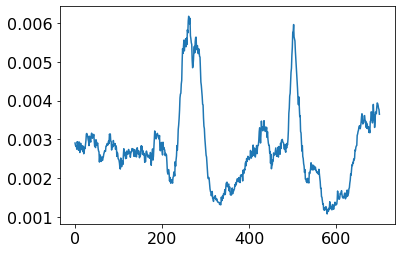

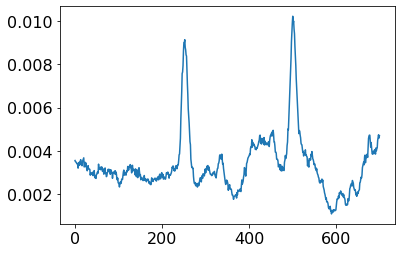

In [28]:
for isim in range(fir_rate_trial_avg[pop_name].shape[0]):
    plt.figure()
    plt.plot(fir_rate_trial_avg[pop_name][isim])
    

#### Drifting gratings

In [32]:
filename = 'fir_rate_layer_pops.npy'

loadpath = os.path.join(sim_data_dir, '2022', 'drifting_gratings', 'dg_2021_dec_16_config', filename)

fir_rate_all_trials_dg = np.load(loadpath, allow_pickle = True)[()]

In [33]:
fir_rate_all_trials_dg[pop_name].shape

KeyError: 'v1'

In [126]:
t_start_sel_dg, t_stop_sel_dg

(250, 950)

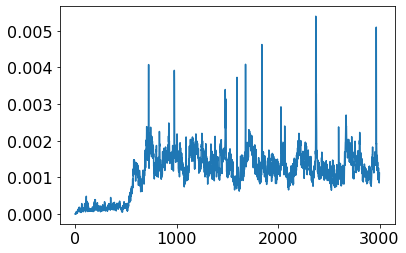

In [128]:
plt.plot(np.mean(fir_rate_all_trials_dg['L4'], axis = 0))

In [28]:
fir_rate_all_stim = dict()
fir_rate_all_stim_trial_avg = dict()
for pop_name in fir_rate_trial_avg.keys():
    fir_rate_trial_avg_temp = fir_rate_trial_avg[pop_name]
    fir_rate_temp_dg = np.mean(fir_rate_all_trials_dg[pop_name][:,t_rem_trial_start+t_start_sel_dg:t_rem_trial_start+t_stop_sel_dg],axis = 0)
    fir_rate_trial_avg_temp[-1] = fir_rate_temp_dg
    fir_rate_all_stim_trial_avg[pop_name] = fir_rate_trial_avg_temp

NameError: name 'fir_rate_all_trials_dg' is not defined

In [ ]:
fir_rate_trial_avg[pop_name].shape

In [141]:
fir_rate_all_trials_dg['L2/3'].shape

(10, 3000)

In [29]:
fir_rate_all_stim = dict()
fir_rate_all_stim_trial_avg = dict()
for pop_name in fir_rate_trial_avg.keys():
    fir_rate_trial_avg_temp = fir_rate_trial_avg[pop_name]
    fir_rate_temp_dg = np.mean(fir_rate_all_trials_dg[pop_name][:,t_rem_trial_start+t_start_sel_dg:t_rem_trial_start+t_stop_sel_dg],axis = 0)
    fir_rate_trial_avg_temp[-1] = fir_rate_temp_dg
    fir_rate_all_stim_trial_avg[pop_name] = fir_rate_trial_avg_temp

NameError: name 'fir_rate_all_trials_dg' is not defined

In [30]:
fir_rate_trial_avg['v1'].shape

(1, 700)

In [29]:
fir_rate_all_stim_trial_avg = fir_rate_trial_avg

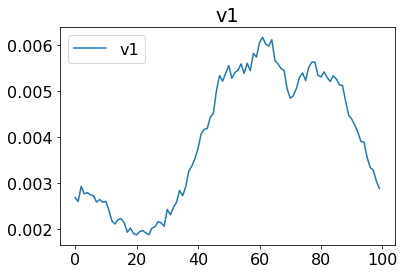

In [30]:
isim = 0
plt.figure()
for pop_name in fir_rate_all_stim_trial_avg.keys():
    #for isim in range(fir_rate_all_stim_trial_avg[pop_name].shape[0]):
        

    plt.plot(fir_rate_all_stim_trial_avg[pop_name][isim][tstim_onset_sim:tstim_onset_sim+100], label = pop_name)

    plt.title(pop_name)
plt.legend()

In [45]:
fir_rate_all_stim_trial_avg_temp.shape

NameError: name 'fir_rate_all_stim_trial_avg_temp' is not defined

In [41]:
sims_spike_trains_layer_pops[sim_name].keys()

dict_keys(['v1'])

In [46]:
np.array(fir_rate_all_stim_trial_avg_temp).shape

NameError: name 'fir_rate_all_stim_trial_avg_temp' is not defined

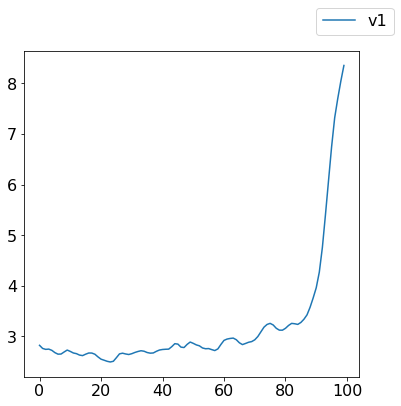

In [31]:
fig, axes = plt.subplots(figsize = (6,6))

ax = axes


fir_rate_all_layerpops = np.zeros((len(sims_spike_trains_layer_pops[sim_name].keys()),trial_dur_sim))

ipop = 0
for layer_pop_name, sim_spike_trains_layer_pops in sims_spike_trains_layer_pops[sim_name].items():
    
    fir_rate_layerpop = np.mean(np.mean(sim_spike_trains_layer_pops, axis = 0), axis = 0)
    
    fir_rate_all_layerpops[ipop] = fir_rate_layerpop*1E3
    
    fir_rate_layerpop_plot = fir_rate_layerpop[tstim_onset_sim:tstim_onset_sim+100]
    
    fir_rate_layerpop_plot = gaussian_filter1d(fir_rate_layerpop_plot, sigma = 1)*1E3
    
    ax.plot(fir_rate_layerpop_plot, label = layer_pop_name)
    
    ipop += 1
    
fig.legend()

In [259]:
sims_spike_trains_layer_pops[sim_name][pop_name].shape

KeyError: '2022_jan_07'

In [33]:
43394/51000

0.8508627450980392

In [32]:
ncells = 0
for layer_pop_name, sim_spike_trains_layer_pops in sims_spike_trains_layer_pops[sim_name].items():
    ncells += sim_spike_trains_layer_pops.shape[0]
    print(sim_spike_trains_layer_pops.shape[0], ncells)

43394 43394


In [33]:
t_start = 0#tstim_onset_sim
t_stop = -1#trial_dur#tstim_onset_sim+stim_dur

In [34]:
subtract_baseline = False
baseline_presubtracted = False
if subtract_baseline:
    baseline_end = 200
    baseline_string = 'no_baseline'
else:
    baseline_end = 0
    if baseline_presubtracted:
        baseline_string = 'baseline_pre_subtracted'
    else:
        baseline_string = 'w_baseline'
        
baseline_string

'w_baseline'

In [35]:
mua_sims_trial_avg.shape

(2, 22, 700)

In [36]:
npop_guess = 1

In [37]:
'''This script runs a standard LPA on MUA data'''


CASENAME = 'mua_sim_w_LGN_input_and_v1v1_connects_modified'
 
SETNAME_MUA = 'mua'
SETNAME_LFP = 'lfp'

MUA = np.zeros((mua_sims_trial_avg.shape[0], mua_sims_trial_avg.shape[2], mua_sims_trial_avg.shape[1]))
for istim in range(MUA.shape[0]):
    MUA[istim] = mua_sims_trial_avg[istim].T
LFP = np.zeros_like(MUA)

###################################################################
# initializing the LPA_signal

nstim, ntime, nchan = MUA.shape
# ntime, nchan = MUA.shape

z_start = 0.   # depth of first electrode in mm
z_space = 0.04  # electrode spacing in mm

S_dict = {
    'mua_data' : MUA,
    'lfp_data' : LFP,
    'dt' : 1,
    'z_start' : z_start,
    'z_space' : z_space,
    'casename' : CASENAME,
    'tstim' : baseline_end,
    'sub_at' : 'base',
    'verbose' : True
    }

lpa_signal = LPA_Signal(**S_dict)

####################################################################
# Initial guess

npop_guess = npop_guess

x0 = np.zeros(3*npop_guess)



####################################################################
# set up arguments for solving

maxpos = z_start + (nchan - 1) * z_space
if npop_guess > 3:
    maxpopwidth = 0.2
elif npop_guess == 3:
    maxpopwidth = 0.2
elif npop_guess == 2:
    maxpopwidth = 0.5
else:
    maxpopwidth = 1
maxslopewidth = z_space

# lower bounds
lb = npop_guess * [z_start] + 2 * npop_guess * [0]  
# upper bounds
ub = npop_guess * [maxpos] + npop_guess * [maxpopwidth] + npop_guess * [maxslopewidth]

# put any arguments passed to the initialization of the solver here,
# see documentation for openopt.NLP for details.
init_args = {
     'maxIter' : 300,
     'maxFunEvals' : 100000,
     'maxTime' : 600,
     'maxCPUTime' : 1000,
     'maxNonSuccess' : 30
    }

# There are also some additional arguments that could be passed to the
# call function of the solver, but most of this will be handled inside
# the call function for lpa_signal (like *x0* and *plot*)
solve_args = {}

# If you subclassed LPA_Signal() and wrote your own error function
# that needs additional arguments, you can put it in the *f_args*
# tuple. Remember that the first argument to the error function is
# always the parameters to be fitted, but this is handled under the
# hood. Only additional (only positional) arguments goes into *f_args*
f_args = ()

##################################################################
# Solve mua
solve_dict = {
    'init_args' : init_args,
    'solve_args' : solve_args,
    'f_args' : f_args,
    'plot' : False
    }
mode = 'mua'
solver = 'de'
r_lpa_MUA, Mmat_lpa, rmat_lpa, Mphi_lpa, h_list, err_wo_pen = lpa_signal(mode, solver, x0, lb, ub, **solve_dict)



glp_solvers = ['galileo' ,'pswarm', 'de', 'stogo', 'isres', 'mlsl']
nlp_solvers = ['ralg', 'scipy_cobyla', 'algencan', 'scipy_slsqp',
               'mma', 'auglag', 'ipopt', 'lincher', 'scipy_fmin',
               'scipy_lbfgsb']

# rmat and MPhi does not belong in lpa_signal, just put it there for
# safekeeping.
#rmat = lpa_signal.rmat
#Mphi = lpa_signal.Mphi
#del lpa_signal.rmat
#del lpa_signal.Mphi

This is class *LPA_Signal* in *pyLPA* module
Solving for mua part of signal
self.pen_fac:  0

------------------------- OpenOpt 0.5629 -------------------------
problem: unnamed   type: GLP    goal: minimum
solver: de
variables: 3
constaints:  linear {3 ineq  0 eq}
  iter  objFunVal  log10(maxResidual)  
    0  1.000e+00            -100.00 
   10  1.724e-01            -100.00 
   20  1.721e-01            -100.00 
   30  1.721e-01            -100.00 
   40  1.721e-01            -100.00 
   50  1.721e-01            -100.00 
   60  1.721e-01            -100.00 
   69  1.721e-01            -100.00 
istop: 11 (Non-Success Number > maxNonSuccess = 30)
Solver:   Time Elapsed = 0.64  	CPU Time Elapsed = 5.09
objFuncValue: 0.17213689 (feasible, MaxResidual = 0)


In [38]:
rmat_lpa.shape

(2, 700, 1)

In [39]:
layer_borders = np.array([0, 100, 310, 430, 650, 850])

In [40]:
hitmonchan = ['#0f0f0f', '#ccb37a', '#a38a72', '#c4b3c4', '#59400f', '#bc3049', '#edd49b', '#a39ba3', '#614972', '#e56149', '#8a1f00', '#fe9359', '#fef5fe', '#ddccdd']
magneton = ['#383030', '#0f0f0f', '#8ab3a3', '#d4f5dd', '#514949', '#fefefe', '#8a8a8a', '#598261', '#b3d4bc', '#fe8a49', '#51ccf5', '#ed1700', '#2882ab', '#b3b3b3', '#d4d4d4']

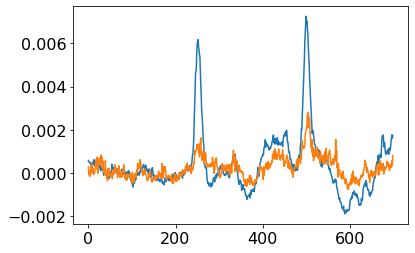

In [41]:
for ipop in range(np.array(list(fir_rate_all_stim_trial_avg.values())).shape[0]):
    fir_rate_plot_test = np.array(list(fir_rate_all_stim_trial_avg.values()))[ipop, istim].copy()
    
    norm_val = np.array(list(fir_rate_all_stim_trial_avg.values()))[:, istim].copy().max()
    
    #fir_rate_plot_test = fir_rate_plot_test/norm_val
    
    fir_rate_plot_test -= np.mean(fir_rate_plot_test[:tstim_onset_sim])
    
    rmat_lpa_plot_test = rmat_lpa[istim, :, ipop]-np.mean(rmat_lpa[istim,:tstim_onset_sim,ipop])
    
    plt.plot(fir_rate_plot_test)
    plt.plot(rmat_lpa_plot_test)

In [42]:
np.corrcoef(fir_rate_plot_test, rmat_lpa_plot_test)

array([[1.        , 0.78038945],
       [0.78038945, 1.        ]])

In [43]:
Mmat_lpa.shape

(22, 1)

In [44]:
nchan_lim*40

880

"savepath = os.path.join(fig_dir, baseline_string, str(npop_guess)+'pops', fig_name)\n\nif not os.path.exists(os.path.join(fig_dir, baseline_string)):\n    os.mkdir(os.path.join(fig_dir, baseline_string))\n\nif not os.path.exists(os.path.join(fig_dir, baseline_string, str(npop_guess)+'pops')):\n    os.mkdir(os.path.join(fig_dir, baseline_string, str(npop_guess)+'pops'))"

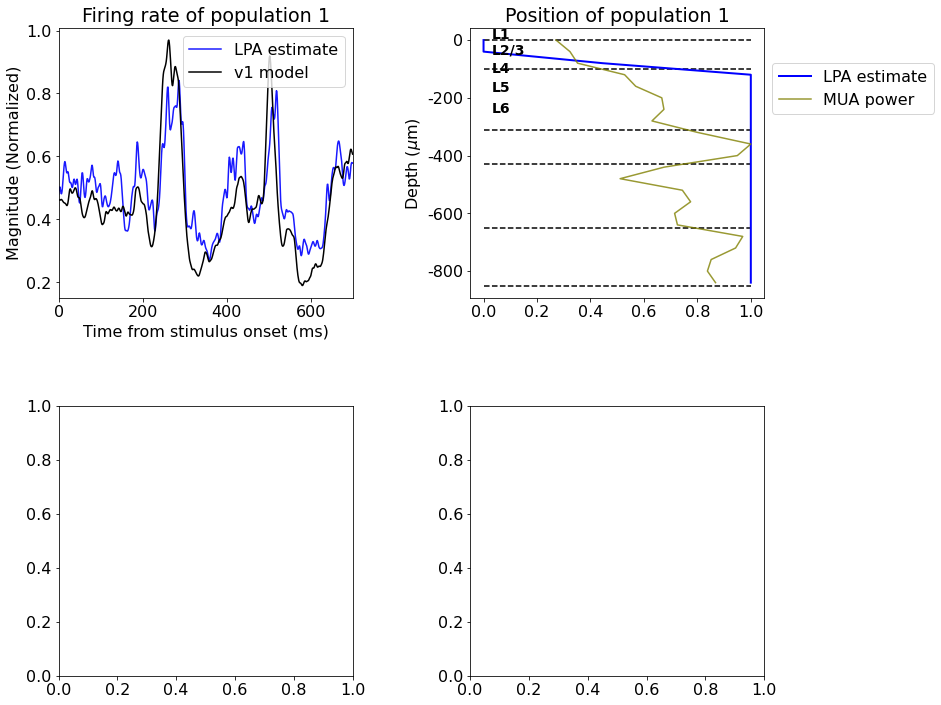

In [45]:
fig, ax = plt.subplots(ncols = 2, nrows =np.max([npop_guess,2]), figsize = (14, 5*np.max([npop_guess,2])))

fig.subplots_adjust(hspace = 0.4, wspace = 0.4, left = 0.1, right = 0.8, bottom = 0.05, top = 0.95)

t = np.arange(rmat_lpa.shape[1])
channel = np.arange(nchan)
sigma = 2

istim = 0

pop_colors = ['b', 'g', 'darkorange', 'blueviolet', 'peru']
pop_colors_w_lgn = ['lime', 'b', 'g', 'darkorange', 'blueviolet', 'peru']
for i, layer_pop_name in zip(range(npop_guess), list(fir_rate_all_stim_trial_avg.keys())):
    fir_rate_lpa_plot = rmat_lpa[istim,:,i]/rmat_lpa[istim].max()
    fir_rate_lpa_plot = gaussian_filter1d(fir_rate_lpa_plot, sigma = sigma)
    ax[i,0].plot(t, fir_rate_lpa_plot, color = pop_colors[i], alpha=0.9, label='LPA estimate')
    
    fir_rate_all_stim_plot = fir_rate_all_stim_trial_avg[layer_pop_name].copy()
    fir_rate_stim_plot = fir_rate_all_stim_plot[istim]
    
    norm_val = np.array(list(fir_rate_all_stim_trial_avg.values()))[:, istim].copy().max()
    
    if 'no_baseline' in baseline_string:
        fir_rate_stim_plot -= np.mean(fir_rate_stim_plot[:tstim_onset_sim])
    
    #fir_rate_layerpop = np.mean(np.mean(sim_spike_trains_layer_pops, axis = 0), axis = 0)
    #if subtract_baseline or baseline_presubtracted:
        #fir_rate_layerpop -= np.mean(fir_rate_layerpop[:tstim_onset_sim])
    
    fir_rate_stim_plot = fir_rate_stim_plot/norm_val
    #fir_rate_stim_plot = fir_rate_stim_plot#[t_start:t_stop]#-np.mean(fir_rate_layerpop[:tstim_onset_sim])
    fir_rate_stim_plot = gaussian_filter1d(fir_rate_stim_plot, sigma = sigma)
    ax[i,0].plot(fir_rate_stim_plot, color = 'k', label = layer_pop_name+' model')
    
    ax[i,0].margins(x=0)
    if i == npop_guess-1:
        ax[i,0].set_xlabel('Time from stimulus onset (ms)')
    ax[i,0].set_ylabel('Magnitude (Normalized)')
    #ax[i,0].set_ylim([-0.0,1])
    
    ax[i,0].legend()
    
    ax[i,1].plot(Mmat_lpa[:,i], channel, lw = 2, alpha=1, label='LPA estimate', color = pop_colors[i])
    ax[i,1].invert_yaxis()
    ax[i,1].set_ylabel('Depth ($\mu$m)')
    ax[i,1].set_yticks(np.arange(0,nchan_lim+5, 5))
    ax[i,1].set_yticklabels(-np.arange(0,1000,200))
    #ax[i,1].grid()
    
    for ilayer, border in enumerate(layer_borders):
        ax[i,1].hlines(y = border/1000*(nchan_sim-1), xmin = 0, xmax = 1, linestyle = '--')
        
    mua_power = np.mean(MUA[istim, t_start:t_stop], axis = 0)
    mua_power_plot = mua_power/mua_power.max()
    
    #ax[i, 1].plot(mua_power_plot, channel, magneton[10], alpha = 0.8, label = 'MUA power')
    ax[i,1].legend(bbox_to_anchor = (1, 0.9))
    
    
    mua_power = np.mean(MUA[istim], axis = 0)
    mua_power_plot = mua_power/mua_power.max()
    
    ax[i, 1].plot(mua_power_plot, channel, 'olive', alpha = 0.8, label = 'MUA power')
    ax[i,1].legend(bbox_to_anchor = (1, 0.9))
    
    yshift = i*0.192-i*i*0.00009
    plt.figtext(x = 0.53, y = 0.935-yshift, s = 'L1', fontsize = 14, fontweight = 560)
    plt.figtext(x = 0.53, y = 0.913-yshift, s = 'L2/3', fontsize = 14, fontweight = 560)
    plt.figtext(x = 0.53, y = 0.888-yshift, s = 'L4', fontsize = 14, fontweight = 560)
    plt.figtext(x = 0.53, y = 0.862-yshift, s = 'L5', fontsize = 14, fontweight = 560)
    plt.figtext(x = 0.53, y = 0.832-yshift, s = 'L6', fontsize = 14, fontweight = 560)
    
    #plt.figtext(x=0.3, y = 0.7-yshift, s = 'Stim.\noffset')
    
    ax[i,0].set_title('Firing rate of population '+str(i+1))
    ax[i,1].set_title('Position of population '+str(i+1))
    
fig_name = 'mua_decomp_mua_'+baseline_string+'_both_flash.png'

savepath = fig_dir

if not os.path.exists(savepath):
    os.mkdir(savepath)

'''savepath = os.path.join(fig_dir, baseline_string, str(npop_guess)+'pops', fig_name)

if not os.path.exists(os.path.join(fig_dir, baseline_string)):
    os.mkdir(os.path.join(fig_dir, baseline_string))

if not os.path.exists(os.path.join(fig_dir, baseline_string, str(npop_guess)+'pops')):
    os.mkdir(os.path.join(fig_dir, baseline_string, str(npop_guess)+'pops'))'''

#fig.savefig(savepath, facecolor = 'w')

In [60]:
fir_rate_all_stim_plot[istim].shape

(700,)

In [61]:
fig_dir

'Figures/for_meeting_w_Gaute_April_14'

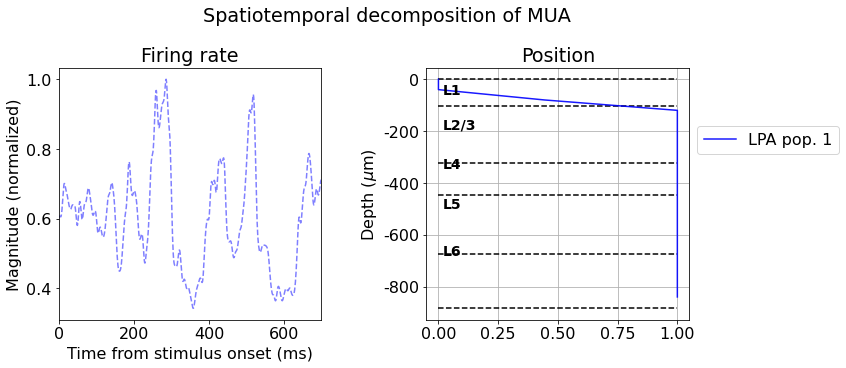

In [94]:
fig, ax = plt.subplots(ncols = 2, nrows =1, figsize = (12, 5))

fig.subplots_adjust(wspace = 0.4, left = 0.07, right = 0.8, bottom = 0.12, top = 0.82)

t = np.arange(ntime)
channel = np.arange(nchan)
istim = 0

for i in range(npop_guess):
    fir_rate_lpa_plot = rmat_lpa[istim,:,i]#[:,stim_onset_mark:stim_onset_mark+100,i]#/rmat_lpa[:,stim_onset_mark:stim_onset_mark+100,:].max()
    #fir_rate_lpa_plot = np.mean(fir_rate_lpa_plot, axis = 0)
    fir_rate_lpa_plot = gaussian_filter1d(fir_rate_lpa_plot,sigma = 3)
    fir_rate_lpa_plot = fir_rate_lpa_plot/gaussian_filter(rmat_lpa[0,:,:], sigma = (3,0)).max()
    ax[0].plot(fir_rate_lpa_plot, '--', color = pop_colors[i], alpha=0.5, label='LPA estimate')
    #ax[i,0].plot(t, MUA_time[i]*1E3, alpha=0.5, label='ground truth')
    ax[0].set_xlabel('Time from stimulus onset (ms)')
    ax[0].set_ylabel('Magnitude (normalized)')
    #ax[1,0].set_ylabel('Magnitude (a. u.)')
    
    ax[1].plot(Mmat_lpa[:,i], channel, alpha=0.9, color = pop_colors[i], label='LPA pop. '+str(i+1))
    #ax[i,1].plot(M[i], channel, alpha=0.5, label='ground truth')
    ax[1].set_ylabel('Channel')
    ax[1].grid()
    
    ax[0].set_title('Firing rate')
    ax[1].set_title('Position')
    

ax[0].margins(x=0)
    
ax[1].invert_yaxis()
ax[1].legend(bbox_to_anchor = (1,0.8))

ax[1].set_ylabel('Depth ($\mu$m)')
ax[1].set_yticks(np.arange(0,25+5,5))
ax[1].set_yticklabels(-np.arange(0,1000+200,200))

#ax[0].set_xticks(np.arange(0,100+20,20))

fig.suptitle('Spatiotemporal decomposition of MUA', y = 0.99, x = 0.45)

for ilayer, border in enumerate(layer_borders):
    ax[1].hlines(y = border/1000*nchan_sim, xmin = 0, xmax = 1, linestyle = '--')
    
plt.figtext(x = 0.515, y = 0.745, s = 'L1', fontsize = 14, fontweight = 560)
plt.figtext(x = 0.515, y = 0.65, s = 'L2/3', fontsize = 14, fontweight = 560)
plt.figtext(x = 0.515, y = 0.54, s = 'L4', fontsize = 14, fontweight = 560)
plt.figtext(x = 0.515, y = 0.43, s = 'L5', fontsize = 14, fontweight = 560)
plt.figtext(x = 0.515, y = 0.3, s = 'L6', fontsize = 14, fontweight = 560)

fig_name = 'mua_decomp_temp_and_spat_profiles_together_mua_'+baseline_string+'.png'
savepath = os.path.join(fig_dir, baseline_string, str(npop_guess)+'pops', fig_name)
#fig.savefig(savepath, facecolor = 'w')

In [46]:
include_lgn = True
pop_names = []
if include_lgn:
    pop_names.append('LGN')

if npop_guess == 4:
    pop_names.append('L2/3')
    pop_names.append('L4')
    pop_names.append('L5')
    pop_names.append('L6')
elif npop_guess == 3:
    pop_names.append('L2/3 and L4')
    pop_names.append('L5')
    pop_names.append('L6')
elif npop_guess == 2:
    pop_names.append('Upper layers')
    pop_names.append('Deep layers')
elif npop_guess == 1:
    pop_names.append('v1')

In [47]:
fig, ax = plt.subplots(ncols = 1, nrows =1, figsize = (8, 5))

fig.subplots_adjust(left = 0.15, right = 0.65, bottom = 0.15, top = 0.85)

t = np.arange(ntime)
channel = np.arange(nchan)

for i in range(npop_guess):
    fir_rate_lpa_plot = rmat_lpa[:,tstim_onset_sim:tstim_onset_sim+201,i]#[:,stim_onset_mark:stim_onset_mark+100,i]#/rmat_lpa[:,stim_onset_mark:stim_onset_mark+100,:].max()
    fir_rate_lpa_plot = np.mean(fir_rate_lpa_plot, axis = 0)
    fir_rate_lpa_plot = gaussian_filter1d(fir_rate_lpa_plot,sigma = 3)
    fir_rate_lpa_plot = fir_rate_lpa_plot/gaussian_filter(rmat_lpa[0,tstim_onset_sim:tstim_onset_sim+201,:], sigma = (3,0)).max()
    ax.plot(fir_rate_lpa_plot, color = pop_colors[i], label='LPA est. '+pop_names[i])
    #ax[i,0].plot(t, MUA_time[i]*1E3, alpha=0.5, label='ground truth')
    ax.set_xlabel('Time from stimulus onset (ms)')
    ax.set_ylabel('Magnitude (normalized)')
    #ax[1,0].set_ylabel('Magnitude (a. u.)')
    
    #ax[i,1].plot(M[i], channel, alpha=0.5, label='ground truth')
    
    ax.set_title('LPA est. firing rates')
    

ax.margins(x=0)
    
ax.legend(bbox_to_anchor = (1,0.8))

#fig.suptitle('Spatiotemporal decomposition of MUA', y = 0.99, x = 0.45)


fig_name = 'LPA-est-firing-rates-'+str(npop_guess)+'_pops.png'
savepath = os.path.join(fig_dir, baseline_string, str(npop_guess)+'pops', fig_name)
#fig.savefig(savepath, facecolor = 'w')

### Reconstruct MUA

In [97]:
Mmat_lpa.shape

(22, 1)

In [98]:
rmat_lpa.shape

(2, 700, 1)

In [48]:
MUA_lpa_pop = np.zeros((npop_guess, nstim, nchan, ntime))

for istim in range(nstim):
    for ipop in range(npop_guess):
        MUA_lpa_pop[ipop,istim,:,:] = np.outer(Mmat_lpa[:,ipop], rmat_lpa[istim,:,ipop])

MUA_lpa = np.sum(MUA_lpa_pop, axis=0)

In [49]:
MUA_lpa.shape

(2, 22, 700)

In [50]:
fig, axes = plt.subplots(ncols = 3, figsize = (15, 5), sharex = True, sharey = True)

fig.subplots_adjust(left = 0.08, right = 0.92, bottom = 0.15, top = 0.85)

istim = 0

scale_to_uV = 1E3
ax = axes[0]
MUA_orig_plot = MUA[istim,:].T
cmap_range = np.abs(MUA_orig_plot).max()/2*scale_to_uV
ax.imshow(MUA_orig_plot*scale_to_uV, aspect = 'auto', vmin = 0, vmax = cmap_range)
ax.set_ylabel('Depth ($\mu$m)')
ax.set_yticks(np.arange(0,25+5,5))
ax.set_yticklabels(-np.arange(0,1000+200,200))

ax.set_title('MUA from simulation')

ax = axes[1]
MUA_lpa_plot = MUA_lpa[istim]
#cmap_range = np.abs(MUA_synth).max()/2
ax.imshow(MUA_lpa_plot*scale_to_uV, aspect = 'auto', vmin = 0, vmax = cmap_range)

ax.set_title('Estimated MUA')
ax.set_xlabel('Time from stimulus onset (ms)')

diff = MUA_lpa_plot-MUA_orig_plot
rel_MSE = np.sum(diff**2)/np.sum(MUA**2)

ax = axes[2]
#cmap_range = np.abs(MUA_synth).max()/2
im = ax.imshow(diff*scale_to_uV, aspect = 'auto', vmin = 0, vmax = cmap_range)

ax.set_title('Difference \n(explained variance = '+str(np.round((1-rel_MSE)*100,1))+' %')

ax.set_xticks(np.arange(0,MUA.shape[1], 250))
ax.set_xticklabels(np.arange(0,MUA.shape[1], 250)-tstim_onset_sim)

cbaxes = fig.add_axes([0.93,0.30,0.008, 0.4])
cb = fig.colorbar(im, ax = ax, cax = cbaxes)
cb.set_label('MUA ($\mu$V)')

fig_name = 'mua_plots_mua_'+baseline_string+'.png'
savepath = os.path.join(fig_dir, baseline_string, str(npop_guess)+'pops', fig_name)
#fig.savefig(savepath, facecolor = 'w')

## Load simulation LFP

In [51]:
lfp_sims_all_stim = dict()

#### Flashes

In [52]:
sim_data_dir = '/Users/atleeskelandrimehaug/Dropbox (Simula)/Data/output_sims'

#selected_sims_data_dir = os.path.join(sim_data_dir, '2021', 'jan', '2022_jan_07*')

selected_sims_data_dir = os.path.join(sim_data_dir, '2023', 'flash', 'apr', '*shift*')

#selected_sims_data_dir = os.path.join(sim_data_dir, '2021')

lfp_sims_temp = find_files(selected_sims_data_dir, filename = 'lfp_w_baseline.npy')

lfp_sims = dict()
for sim_name in list(lfp_sims_temp.keys())[::-1]:
    lfp_sims[sim_name] = lfp_sims_temp[sim_name]

#lfp_sims = find_files(selected_sims_data_dir, filename = 'lfp.npy')

for sim_name in list(lfp_sims.keys()):
    if 'jan_07' not in sim_name or 'fb_to_L1' in sim_name or 'w_20um' in sim_name:
        del lfp_sims[sim_name]
        
if len(lfp_sims.keys()) == 1:
    sim_name = list(lfp_sims.keys())[0]
elif len(lfp_sims.keys()) > 1:
    sim_names = list(lfp_sims.keys())
    sim_name = sim_names[0]
print(lfp_sims.keys())

for sim_name in list(lfp_sims.keys()):
    lfp_sims_all_stim[sim_name] = lfp_sims[sim_name]
    
for sim_name in list(lfp_sims.keys()):
    lfp_sims_all_stim_temp = dict()
    lfp_sims_all_stim_temp['all_trials'] = lfp_sims[sim_name]['all_trials']#[:,:,tstim_onset_sim:]
    lfp_sims_all_stim_temp['trial_avg'] = lfp_sims[sim_name]['trial_avg']#[:,tstim_onset_sim:]
    lfp_sims_all_stim[sim_name] = lfp_sims_all_stim_temp

dict_keys(['2022_jan_07_shift', '2022_jan_07_black_shift'])


#### Natural scenes

#### Gabors

#### Drifting gratings

In [121]:
lfp_sims_all_stim

{'2022_jan_07_shift': {'all_trials': array([[[-0.01564578, -0.01630078, -0.01671283, ..., -0.02272766,
           -0.02280385, -0.0231203 ],
          [-0.02230776, -0.0219855 , -0.0211627 , ..., -0.02423141,
           -0.02519137, -0.02597126],
          [-0.02357225, -0.02338581, -0.02302091, ..., -0.02247984,
           -0.02283772, -0.02320616],
          ...,
          [-0.02266027, -0.0221734 , -0.02135181, ..., -0.02208827,
           -0.02162558, -0.02120084],
          [-0.02479732, -0.02397155, -0.02312112, ..., -0.02194348,
           -0.0217347 , -0.02187513],
          [-0.02270222, -0.02246789, -0.02251066, ..., -0.02475949,
           -0.02582995, -0.0266267 ]],
  
         [[-0.0176732 , -0.01850419, -0.01898851, ..., -0.02536848,
           -0.02553042, -0.02592873],
          [-0.02504466, -0.02474049, -0.02386657, ..., -0.02701859,
           -0.0281751 , -0.02909513],
          [-0.02617684, -0.02596472, -0.02570717, ..., -0.02544493,
           -0.02574462, -0.026

### Splice

In [53]:
lfp_sims_all_stim[sim_name]['trial_avg'].shape

(26, 700)

In [54]:
lfp_sims_trial_avg = [[[]]*lfp_sims_all_stim[sim_name]['trial_avg'].shape[0]]
lfp_for_lpa = np.zeros((len(lfp_sims.keys()), nchan_lim, lfp_sims_all_stim[sim_name]['trial_avg'].shape[1]))

for isim, sim_name in enumerate(lfp_sims_all_stim.keys()):
    lfp_for_lpa[isim] = lfp_sims_all_stim[sim_name]['trial_avg'][:nchan_lim]
    print(sim_name)
    for ichan in range(lfp_sims_all_stim[sim_name]['trial_avg'].shape[0]):
        print(lfp_sims_all_stim[sim_name]['trial_avg'].shape)
        if len(lfp_sims_trial_avg[0][ichan]) == 0:
            lfp_sims_trial_avg[0][ichan] = lfp_sims_all_stim[sim_name]['trial_avg'][ichan]
        else:
            lfp_sims_trial_avg[0][ichan] = np.concatenate([lfp_sims_trial_avg[0][ichan], \
                                                 lfp_sims_all_stim[sim_name]['trial_avg'][ichan]])

lfp_sims_trial_avg = np.array(lfp_sims_trial_avg)

2022_jan_07_shift
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
2022_jan_07_black_shift
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)
(26, 700)


In [124]:
lfp_sims_trial_avg.shape

(1, 26, 1400)

### Compute CSD

In [55]:
method='DeltaiCSD'

#csd_for_lpa = np.zeros((nstim, nchan, ntime))
csd_for_lpa = np.zeros((nstim, nchan_lim, ntime))

csd_sims = dict()
for isim, sim_name in enumerate(lfp_sims_all_stim.keys()):
    print(sim_name)
    lfp_temp = lfp_sims_all_stim[sim_name]['trial_avg'][:nchan_lim]
    
    csd_temp = compute_csd(lfp_temp, method = 'delta', h = 40*1E-6*pq.m, gauss_filter = (1.4,0),
                        coord_electrodes = np.linspace(0,840E-6, lfp_temp.shape[0]) * pq.m)
    
    csd_for_lpa[isim] = csd_temp
    
    csd_sims[sim_name] = csd_temp

2022_jan_07_shift
2022_jan_07_black_shift


In [56]:
csd_sims[sim_name].sum(axis = 0).max()*scale_to_mA

NameError: name 'scale_to_mA' is not defined

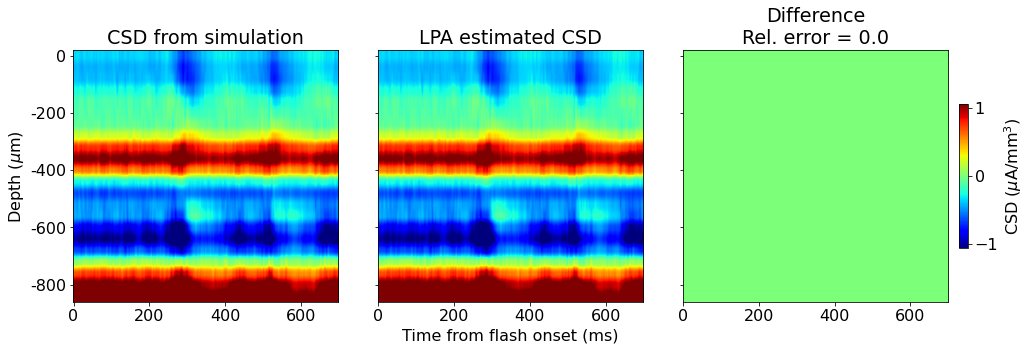

In [57]:
fig, axes = plt.subplots(ncols = 3, figsize = (15, 5), sharex = True, sharey = True)
fig.subplots_adjust(wspace = 0.15, left = 0.08, right = 0.89, bottom = 0.15, top = 0.85)

scale_to_mA = 1E-3

sim_name = '2022_jan_07_shift'

ax = axes[0]
csd_orig_plot = csd_sims[sim_name]
cmap_range = np.abs(csd_orig_plot).max()/2*scale_to_mA
ax.imshow(csd_orig_plot*scale_to_mA, cmap = 'jet', aspect='auto', vmin = -cmap_range, vmax = cmap_range)

ax.set_ylabel('Depth ($\mu$m)')
ax.set_yticks(np.arange(0,25+5,5))
ax.set_yticklabels(-np.arange(0,1000+200,200))

ax.set_title('CSD from simulation')

ax = axes[1]
isim = 0
'''csd_lpa_plot = csd_lpa[:,tstim_onset_sim:tstim_onset_sim+101]'''
csd_lpa_plot = (csd_for_lpa[isim])#.T-np.mean(csd_lpa[:,:tstim_onset_sim], axis = 1)).T

#cmap_range = np.abs(MUA_synth).max()/2
ax.imshow(csd_lpa_plot*scale_to_mA, cmap = 'jet', aspect='auto', vmin = -cmap_range, vmax = cmap_range)

ax.set_title('LPA estimated CSD')

ax.set_xlabel('Time from flash onset (ms)')

diff = csd_lpa_plot-csd_orig_plot.magnitude
rel_MSE = np.sum(diff**2)/np.sum(csd_orig_plot.magnitude**2)

ax = axes[2]
#cmap_range = np.abs(MUA_synth).max()/2
im =ax.imshow(diff*scale_to_mA, cmap = 'jet', aspect='auto', vmin = -cmap_range, vmax = cmap_range)
ax.set_title('Difference\nRel. error = '+str(np.round(rel_MSE*100,4)))

#ax.set_xticks(np.arange(0,100+20,20))
#ax.set_xticklabels(np.arange(0,100+20,20))
#ax.set_xlim([0,100])

cbaxes = fig.add_axes([0.9,0.30,0.008, 0.4])
cb = fig.colorbar(im, ax = ax, cax = cbaxes)
cb.set_label('CSD ($\mu$A/mm$^3$)')

fig_name = 'csd_plots.png'
#savepath = os.path.join(fig_dir, baseline_string, str(npop_guess)+'pops', lgn_string, fir_rate_decomp_string, fig_name)
#fig.savefig(savepath, facecolor = 'w')

In [58]:
lfp_sims_trial_avg.shape

(1, 26, 1400)

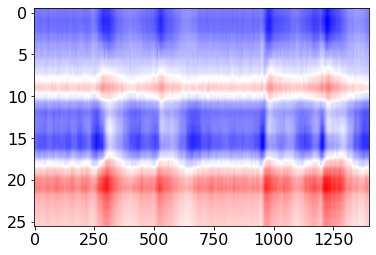

In [59]:
plt.imshow(lfp_sims_trial_avg[0], cmap = 'bwr', aspect = 'auto')

In [60]:
lfp_sims_all_trials = [[[]]*lfp_sims_all_stim[sim_name]['all_trials'].shape[1]]

for sim_name in lfp_sims_all_stim.keys():
    print(sim_name)
    for itrial in range(lfp_sims_all_stim[sim_name]['all_trials'].shape[0]):
        for ichan in range(lfp_sims_all_stim[sim_name]['all_trials'].shape[1]):
            if len(lfp_sims_all_trials[0][ichan]) == 0:
                lfp_sims_all_trials[0][ichan] = lfp_sims_all_stim[sim_name]['all_trials'][itrial, ichan]
            else:
                lfp_sims_all_trials[0][ichan] = np.concatenate([lfp_sims_all_trials[0][ichan], \
                                                     lfp_sims_all_stim[sim_name]['all_trials'][itrial, ichan]])

lfp_sims_all_trials = np.array(lfp_sims_all_trials)

2022_jan_07_shift
2022_jan_07_black_shift


IndexError: index 2 is out of bounds for axis 0 with size 2

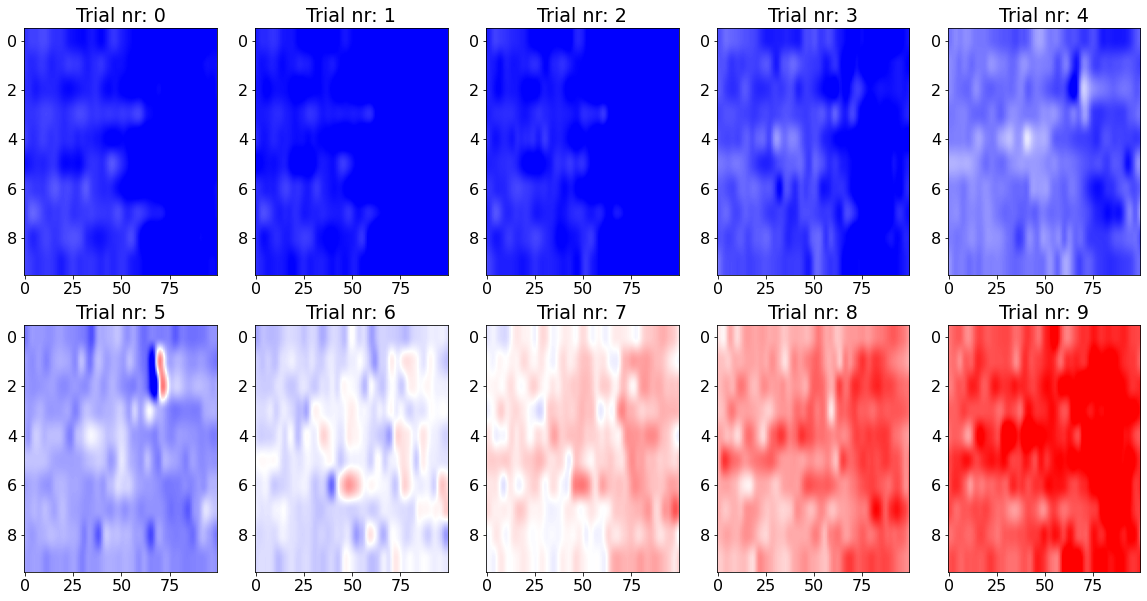

In [212]:
### tstim_onset_sim_dg = 500

fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 10))

sim_name = list(lfp_sims.keys())[0]

lfp_temp = lfp_sims[sim_name]['all_trials']
    
cmap_range = np.abs(lfp_temp).max()/3


isim = 1
for itrial in range(lfp_temp.shape[0]):
    irow = itrial // 5
    icol = itrial % 5
    ax = axes[irow,icol]
    lfp_plot = lfp_sims[sim_name]['all_trials'][itrial]
    #for ichan in range(lfp_plot.shape[0]):
    #   lfp_plot[ichan] -= np.mean(lfp_plot[ichan, :tstim_onset_sim_dg])
    
    im = ax.imshow(lfp_plot[:,tstim_onset_sim_dg:tstim_onset_sim_dg+100], cmap = 'bwr', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')
    
    #title = sim_name.split('_')[1]+' '+sim_name.split('_')[2]+' '+sim_name.split('_')[-2]+' '+sim_name.split('_')[-1]
    
    ax.set_title('Trial nr: '+str(itrial))
    
    isim += 1
    
cbaxes = fig.add_axes([0.93, 0.30, 0.015, 0.4])
cb = fig.colorbar(im, ax = ax, cax = cbaxes); 
cb.set_label('(mV)', fontsize = '12')
    

### Construct model population firing rate matrix to use for LFP decomposition instead

In [ ]:
fir_rate_all_stim_trial_avg.keys()

In [213]:
rmat_model = fir_rate_all_stim_trial_avg

## Load LGN input

In [82]:
del fir_rate_lgn_all_stim_trial_avg

NameError: name 'fir_rate_lgn_all_stim_trial_avg' is not defined

In [61]:
fir_rate_lgn_all_stim_trial_avg = np.zeros((nstim, ntime))

#### White flash

In [62]:
model_input_path = '/Users/atleeskelandrimehaug/Repository/cobra_check/V1_model_working_dir/inputs_from_V1_model'
filename = 'lgn_exp_input_NO_ON-OFF_class_10trials_nov_15_short.h5'
loadpath = os.path.join(model_input_path, filename)
file = h5py.File(loadpath, 'r')
neuron_ids_lgn_input = np.array(file['spikes']['gids'])
timestamps_lgn_input = np.array(file['spikes']['timestamps'])
file.close()

In [63]:
ntrials_sim = 10
bins_lgn = np.linspace(0, ntrials_sim*trial_dur_sim, ntrials_sim*trial_dur_sim+1)
fir_rate_lgn_input_w_flash = np.histogram(timestamps_lgn_input, bins = bins_lgn)[0]/17400
fir_rate_lgn_input_w_flash = fir_rate_lgn_input_w_flash.reshape((ntrials_sim, trial_dur_sim))
fir_rate_lgn_input_w_flash = fir_rate_lgn_input_w_flash[:,t_rem_trial_start:]
#fir_rate_lgn_input_w_flash = (fir_rate_lgn_input_w_flash.T - np.mean(fir_rate_lgn_input_w_flash[:,:tstim_onset_sim], axis=1)).T
#fir_rate_lgn_input_w_flash = fir_rate_lgn_input_w_flash[:,tstim_onset_sim:]
fir_rate_lgn_flash_plot = np.mean(fir_rate_lgn_input_w_flash, axis=0)
istim = 0
fir_rate_lgn_all_stim_trial_avg[istim] = fir_rate_lgn_flash_plot
fir_rate_lgn_flash_plot = gaussian_filter1d(fir_rate_lgn_flash_plot, sigma = 2)


fig = plt.figure(figsize = (6,4))

ax = fig.add_subplot(1,1,1)
ax.plot(fir_rate_lgn_flash_plot*1E3, color = 'tab:blue', label = 'LGN input to model')
ax.margins(x=0)
ax.set_ylim([0, 14])
ax.set_ylabel('Firing rate (Hz)')
ax.set_xlabel('Time from flash onset (ms)')
fig.legend(bbox_to_anchor = (0.96, 0.92))

ax.set_title('LGN input to model')

fig.subplots_adjust(left = 0.12, right = 0.95, bottom = 0.15, top = 0.9)

fig_name = 'lgn-input-to-model.png'

#savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')

### Black flash

In [64]:
filename = 'lgn_black_flash_exp_input_NO_ON-OFF_class_10trials_nov_15_short.h5'
loadpath = os.path.join(model_input_path, filename)
file = h5py.File(loadpath, 'r')
neuron_ids_lgn_input = np.array(file['spikes']['gids'])
timestamps_lgn_input = np.array(file['spikes']['timestamps'])
file.close()

In [65]:
tstim_onset_sim

200

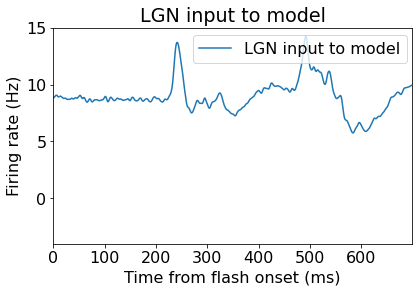

In [66]:
ntrials_sim = 10
bins_lgn = np.linspace(0, ntrials_sim*trial_dur_sim, ntrials_sim*trial_dur_sim+1)
fir_rate_lgn_input_b_flash = np.histogram(timestamps_lgn_input, bins = bins_lgn)[0]/17400
fir_rate_lgn_input_b_flash = fir_rate_lgn_input_b_flash.reshape((ntrials_sim, trial_dur_sim))
fir_rate_lgn_input_b_flash = fir_rate_lgn_input_b_flash[:,t_rem_trial_start:]
#fir_rate_lgn_input_b_flash = (fir_rate_lgn_input_b_flash.T - np.mean(fir_rate_lgn_input_b_flash[:,:tstim_onset_sim], axis=1)).T
#fir_rate_lgn_input_b_flash = fir_rate_lgn_input_b_flash[:,tstim_onset_sim:]
fir_rate_lgn_b_flash_plot = np.mean(fir_rate_lgn_input_b_flash, axis=0)
istim = 1
fir_rate_lgn_all_stim_trial_avg[istim] = fir_rate_lgn_b_flash_plot
fir_rate_lgn_b_flash_plot = gaussian_filter1d(fir_rate_lgn_b_flash_plot, sigma = 2)


fig = plt.figure(figsize = (6,4))

ax = fig.add_subplot(1,1,1)
ax.plot(fir_rate_lgn_b_flash_plot*1E3, color = 'tab:blue', label = 'LGN input to model')
ax.margins(x=0)
ax.set_ylim([-4, 15])
ax.set_ylabel('Firing rate (Hz)')
ax.set_xlabel('Time from flash onset (ms)')
fig.legend(bbox_to_anchor = (0.96, 0.92))

ax.set_title('LGN input to model')

fig.subplots_adjust(left = 0.12, right = 0.95, bottom = 0.15, top = 0.9)

fig_name = 'lgn-input-to-model.png'

#savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')

#### Natural scenes

In [88]:
filename = 'lgn_exp_input_natural_scenes_10trials_with_grayscreen.h5'
loadpath = os.path.join(model_input_path, 'natural_scenes', filename)
file = h5py.File(loadpath, 'r')
neuron_ids_lgn_input = np.array(file['spikes']['gids'])
timestamps_lgn_input = np.array(file['spikes']['timestamps'])
file.close()

In [89]:
ntrials_sim = 10
bins_lgn = np.linspace(0, ntrials_sim*trial_dur_sim, ntrials_sim*trial_dur_sim+1)
fir_rate_lgn_input_ns = np.histogram(timestamps_lgn_input, bins = bins_lgn)[0]/17400
fir_rate_lgn_input_ns = fir_rate_lgn_input_ns.reshape((ntrials_sim, trial_dur_sim))
fir_rate_lgn_input_ns = fir_rate_lgn_input_ns[:,t_rem_trial_start:]
#fir_rate_lgn_input_ns = (fir_rate_lgn_input_ns.T - np.mean(fir_rate_lgn_input_ns[:,:tstim_onset_sim], axis=1)).T
#fir_rate_lgn_input_w_flash = fir_rate_lgn_input_w_flash[:,tstim_onset_sim:]
fir_rate_lgn_ns_plot = np.mean(fir_rate_lgn_input_ns, axis=0)
istim = 2
fir_rate_lgn_all_stim_trial_avg[istim] = fir_rate_lgn_ns_plot
fir_rate_lgn_ns_plot = gaussian_filter1d(fir_rate_lgn_ns_plot, sigma = 2)


fig = plt.figure(figsize = (6,4))

ax = fig.add_subplot(1,1,1)
ax.plot(fir_rate_lgn_ns_plot*1E3, color = 'tab:blue', label = 'LGN input to model')
ax.margins(x=0)
ax.set_ylim([-4, 15])
ax.set_ylabel('Firing rate (Hz)')
ax.set_xlabel('Time from flash onset (ms)')
fig.legend(bbox_to_anchor = (0.96, 0.92))

ax.set_title('LGN input to model')

fig.subplots_adjust(left = 0.12, right = 0.95, bottom = 0.15, top = 0.9)

fig_name = 'lgn-input-to-model.png'

#savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')

IndexError: index 2 is out of bounds for axis 0 with size 2

#### Gabors

In [343]:
filename = 'lgn_exp_input_gabors_10trials_with_grayscreen.h5'
loadpath = os.path.join(model_input_path, 'gabors', filename)
file = h5py.File(loadpath, 'r')
neuron_ids_lgn_input = np.array(file['spikes']['gids'])
timestamps_lgn_input = np.array(file['spikes']['timestamps'])
file.close()

In [344]:
ntrials_sim = 10
bins_lgn = np.linspace(0, ntrials_sim*trial_dur_sim, ntrials_sim*trial_dur_sim+1)
fir_rate_lgn_input_gabors = np.histogram(timestamps_lgn_input, bins = bins_lgn)[0]/17400
fir_rate_lgn_input_gabors = fir_rate_lgn_input_gabors.reshape((ntrials_sim, trial_dur_sim))
fir_rate_lgn_input_gabors = fir_rate_lgn_input_gabors[:,t_rem_trial_start:]
#fir_rate_lgn_input_gabors = (fir_rate_lgn_input_gabors.T - np.mean(fir_rate_lgn_input_gabors[:,:tstim_onset_sim], axis=1)).T
#fir_rate_lgn_input_w_flash = fir_rate_lgn_input_w_flash[:,tstim_onset_sim:]
fir_rate_lgn_gabors_plot = np.mean(fir_rate_lgn_input_gabors, axis=0)
istim = 3
fir_rate_lgn_all_stim_trial_avg[istim] = fir_rate_lgn_gabors_plot
fir_rate_lgn_gabors_plot = gaussian_filter1d(fir_rate_lgn_gabors_plot, sigma = 2)


fig = plt.figure(figsize = (6,4))

ax = fig.add_subplot(1,1,1)
ax.plot(fir_rate_lgn_gabors_plot*1E3, color = 'tab:blue', label = 'LGN input to model')
ax.margins(x=0)
ax.set_ylim([-4, 15])
ax.set_ylabel('Firing rate (Hz)')
ax.set_xlabel('Time from flash onset (ms)')
fig.legend(bbox_to_anchor = (0.96, 0.92))

ax.set_title('LGN input to model')

fig.subplots_adjust(left = 0.12, right = 0.95, bottom = 0.15, top = 0.9)

fig_name = 'lgn-input-to-model.png'

#savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')

IndexError: index 3 is out of bounds for axis 0 with size 2

#### Drifting gratings

In [95]:
filename = 'full3_production_3.0sec_SF0.04_TF2.0_ori90.0_c80.0_gs0.5_spikes_all_trials.h5'
loadpath = os.path.join(model_input_path, 'drifting_gratings_trials_spliced', filename)
file = h5py.File(loadpath, 'r')
neuron_ids_lgn_input = np.array(file['spikes']['gids'])
timestamps_lgn_input = np.array(file['spikes']['timestamps'])
file.close()

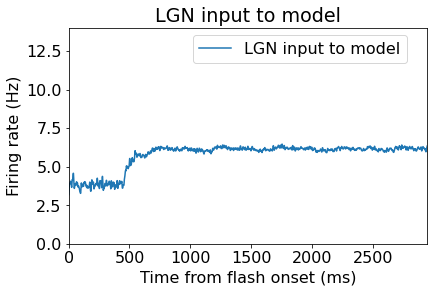

In [96]:
ntrials_sim = 10

bins_lgn = np.linspace(0, ntrials_sim*trial_dur_sim_dg, ntrials_sim*trial_dur_sim_dg+1)
fir_rate_lgn_input_dg = np.histogram(timestamps_lgn_input, bins = bins_lgn)[0]/17400
fir_rate_lgn_input_dg = fir_rate_lgn_input_dg.reshape((ntrials_sim, trial_dur_sim_dg))
fir_rate_lgn_input_dg = fir_rate_lgn_input_dg[:,t_rem_trial_start:]
#fir_rate_lgn_input_dg = (fir_rate_lgn_input_dg.T-np.mean(fir_rate_lgn_input_dg[:,:tstim_onset_sim_dg], axis = 1)).T
#fir_rate_lgn_input_dg = fir_rate_lgn_input_dg[:,tstim_onset_sim_dg:]
fir_rate_lgn_dg_plot = np.mean(fir_rate_lgn_input_dg, axis=0)
istim = 4
fir_rate_lgn_all_stim_trial_avg[istim] = fir_rate_lgn_dg_plot[t_start_sel_dg:t_stop_sel_dg]
fir_rate_lgn_dg_plot = gaussian_filter1d(fir_rate_lgn_dg_plot, sigma = 2)

fig = plt.figure(figsize = (6,4))

ax = fig.add_subplot(1,1,1)
ax.plot(fir_rate_lgn_dg_plot*1E3, color = 'tab:blue', label = 'LGN input to model')
ax.margins(x=0)
ax.set_ylim([0, 14])
ax.set_ylabel('Firing rate (Hz)')
ax.set_xlabel('Time from flash onset (ms)')
fig.legend(bbox_to_anchor = (0.96, 0.92))

ax.set_title('LGN input to model')

fig.subplots_adjust(left = 0.12, right = 0.95, bottom = 0.15, top = 0.9)

fig_name = 'lgn-input-to-model.png'

#savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')

In [67]:
nstim

2

## Load FB input

In [67]:
fir_rate_fb_all_stim_trial_avg = np.zeros((nstim, ntime))

#### White flash

In [68]:
model_input_path = '/Users/atleeskelandrimehaug/Repository/cobra_check/V1_model_working_dir/inputs_from_V1_model'
filename = 'flashes/fb_from_LM_short_20ms_shift.h5'
loadpath = os.path.join(model_input_path, filename)
file = h5py.File(loadpath, 'r')
neuron_ids_fb_input = np.array(file['spikes']['gids'])
timestamps_fb_input = np.array(file['spikes']['timestamps'])
file.close()

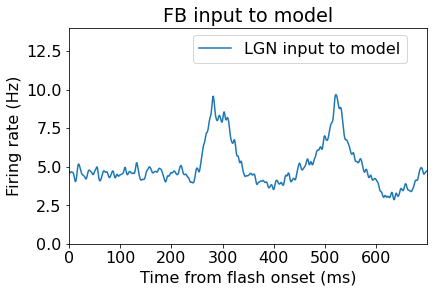

In [69]:
ntrials_sim = 10
bins_fb = np.linspace(0, ntrials_sim*trial_dur_sim, ntrials_sim*trial_dur_sim+1)
fir_rate_fb_input_w_flash = np.histogram(timestamps_fb_input, bins = bins_fb)[0]/1E3
fir_rate_fb_input_w_flash = fir_rate_fb_input_w_flash.reshape((ntrials_sim, trial_dur_sim))
fir_rate_fb_input_w_flash = fir_rate_fb_input_w_flash[:,t_rem_trial_start:]
#fir_rate_lgn_input_w_flash = (fir_rate_lgn_input_w_flash.T - np.mean(fir_rate_lgn_input_w_flash[:,:tstim_onset_sim], axis=1)).T
#fir_rate_lgn_input_w_flash = fir_rate_lgn_input_w_flash[:,tstim_onset_sim:]
fir_rate_fb_flash_plot = np.mean(fir_rate_fb_input_w_flash, axis=0)
istim = 0
fir_rate_fb_all_stim_trial_avg[istim] = fir_rate_fb_flash_plot
fir_rate_fb_flash_plot = gaussian_filter1d(fir_rate_fb_flash_plot, sigma = 2)


fig = plt.figure(figsize = (6,4))

ax = fig.add_subplot(1,1,1)
ax.plot(fir_rate_fb_flash_plot*1E3, color = 'tab:blue', label = 'LGN input to model')
ax.margins(x=0)
ax.set_ylim([0, 14])
ax.set_ylabel('Firing rate (Hz)')
ax.set_xlabel('Time from flash onset (ms)')
fig.legend(bbox_to_anchor = (0.96, 0.92))

ax.set_title('FB input to model')

fig.subplots_adjust(left = 0.12, right = 0.95, bottom = 0.15, top = 0.9)

fig_name = 'FB-input-to-model.png'

#savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')

#### Black flash

In [70]:
model_input_path = '/Users/atleeskelandrimehaug/Repository/cobra_check/V1_model_working_dir/inputs_from_V1_model'
filename = 'flashes/fb_from_LM_black_short_20ms_shift.h5'
loadpath = os.path.join(model_input_path, filename)
file = h5py.File(loadpath, 'r')
neuron_ids_fb_input = np.array(file['spikes']['gids'])
timestamps_fb_input = np.array(file['spikes']['timestamps'])
file.close()

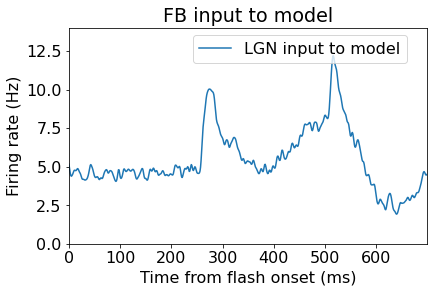

In [71]:
ntrials_sim = 10
bins_fb = np.linspace(0, ntrials_sim*trial_dur_sim, ntrials_sim*trial_dur_sim+1)
fir_rate_fb_input_w_flash = np.histogram(timestamps_fb_input, bins = bins_fb)[0]/1E3
fir_rate_fb_input_w_flash = fir_rate_fb_input_w_flash.reshape((ntrials_sim, trial_dur_sim))
fir_rate_fb_input_w_flash = fir_rate_fb_input_w_flash[:,t_rem_trial_start:]
#fir_rate_lgn_input_w_flash = (fir_rate_lgn_input_w_flash.T - np.mean(fir_rate_lgn_input_w_flash[:,:tstim_onset_sim], axis=1)).T
#fir_rate_lgn_input_w_flash = fir_rate_lgn_input_w_flash[:,tstim_onset_sim:]
fir_rate_fb_flash_plot = np.mean(fir_rate_fb_input_w_flash, axis=0)
istim = 1
fir_rate_fb_all_stim_trial_avg[istim] = fir_rate_fb_flash_plot
fir_rate_fb_flash_plot = gaussian_filter1d(fir_rate_fb_flash_plot, sigma = 2)


fig = plt.figure(figsize = (6,4))

ax = fig.add_subplot(1,1,1)
ax.plot(fir_rate_fb_flash_plot*1E3, color = 'tab:blue', label = 'LGN input to model')
ax.margins(x=0)
ax.set_ylim([0, 14])
ax.set_ylabel('Firing rate (Hz)')
ax.set_xlabel('Time from flash onset (ms)')
fig.legend(bbox_to_anchor = (0.96, 0.92))

ax.set_title('FB input to model')

fig.subplots_adjust(left = 0.12, right = 0.95, bottom = 0.15, top = 0.9)

fig_name = 'FB-input-to-model.png'

#savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')

### Background input

In [72]:
fir_rate_bkg_all_stim_trial_avg = np.zeros((nstim, ntime))

In [73]:
model_input_path = '/Users/atleeskelandrimehaug/Repository/cobra_check/V1_model_working_dir/inputs_from_V1_model'
filename = 'bkg_nest.h5'
loadpath = os.path.join(model_input_path, filename)
file = h5py.File(loadpath, 'r')
neuron_ids_bkg_input = np.array(file['spikes']['gids'])
timestamps_bkg_input = np.array(file['spikes']['timestamps'])
file.close()

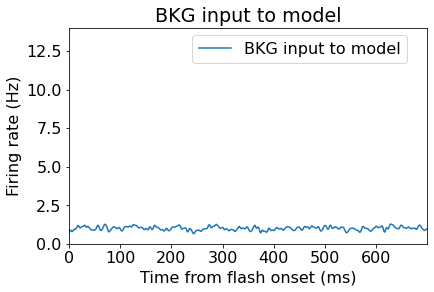

In [74]:
ntrials_sim = 10
bins_bkg = np.linspace(0, ntrials_sim*trial_dur_sim, ntrials_sim*trial_dur_sim+1)
fir_rate_bkg_input_w_flash = np.histogram(timestamps_bkg_input, bins = bins_bkg)[0]/1E3
fir_rate_bkg_input_w_flash = fir_rate_bkg_input_w_flash.reshape((ntrials_sim, trial_dur_sim))
fir_rate_bkg_input_w_flash = fir_rate_bkg_input_w_flash[:,t_rem_trial_start:]
#fir_rate_lgn_input_w_flash = (fir_rate_lgn_input_w_flash.T - np.mean(fir_rate_lgn_input_w_flash[:,:tstim_onset_sim], axis=1)).T
#fir_rate_lgn_input_w_flash = fir_rate_lgn_input_w_flash[:,tstim_onset_sim:]
fir_rate_bkg_flash_plot = np.mean(fir_rate_bkg_input_w_flash, axis=0)
for istim in range(2):
    fir_rate_bkg_all_stim_trial_avg[istim] = fir_rate_bkg_flash_plot

fir_rate_bkg_flash_plot = gaussian_filter1d(fir_rate_bkg_flash_plot, sigma = 2)


fig = plt.figure(figsize = (6,4))

ax = fig.add_subplot(1,1,1)
ax.plot(fir_rate_bkg_flash_plot*1E3, color = 'tab:blue', label = 'BKG input to model')
ax.margins(x=0)
ax.set_ylim([0, 14])
ax.set_ylabel('Firing rate (Hz)')
ax.set_xlabel('Time from flash onset (ms)')
fig.legend(bbox_to_anchor = (0.96, 0.92))

ax.set_title('BKG input to model')

fig.subplots_adjust(left = 0.12, right = 0.95, bottom = 0.15, top = 0.9)

fig_name = 'BKG-input-to-model.png'

#savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')

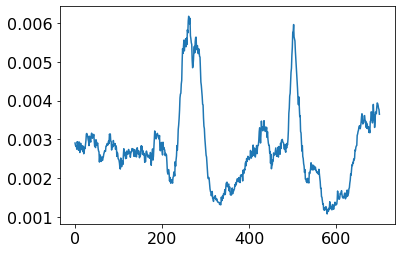

In [75]:
istim = 0
for ipop, pop_name in enumerate(fir_rate_all_stim_trial_avg.keys()):
    plt.figure()
    plt.plot(fir_rate_all_stim_trial_avg[pop_name][istim])

In [119]:
fir_rate_lgn_all_stim_trial_avg.shape

(2, 700)

In [120]:
np.array(list(fir_rate_all_stim_trial_avg.values()))

array([[[0.00290593, 0.00284602, 0.00282297, ..., 0.00379776,
         0.00377472, 0.00364797],
        [0.00355118, 0.00349357, 0.00348435, ..., 0.00474029,
         0.00458819, 0.00470342]]])

In [76]:
rmat_model_w_lgn_fb = np.zeros((nstim, fir_rate_lgn_all_stim_trial_avg.shape[1], npop_guess+3))
rmat_model_w_lgn_fb[:, :, 0] = fir_rate_lgn_all_stim_trial_avg

for ipop, pop_name in enumerate(fir_rate_all_stim_trial_avg.keys()):
    rmat_model_w_lgn_fb[:, :, 1+ipop] = fir_rate_all_stim_trial_avg[pop_name]
    
rmat_model_w_lgn_fb[:, :, -2] = fir_rate_fb_all_stim_trial_avg
rmat_model_w_lgn_fb[:, :, -1] = fir_rate_bkg_all_stim_trial_avg

In [77]:
rmat_model_w_lgn_fb[:, :, 1+ipop].shape

(2, 700)

In [78]:
rmat_model_w_lgn_fb.shape

(2, 700, 4)

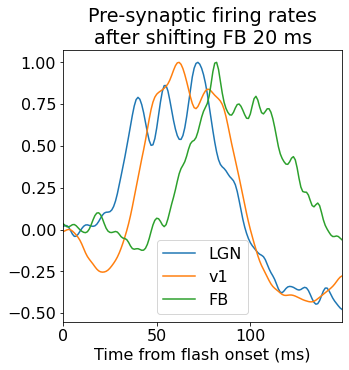

In [131]:
istim = 0
fig, ax = plt.subplots(figsize = (5,5))
for ipop in range(rmat_model_w_lgn_fb.shape[-1]):
    if ipop > 2:
        continue
    fir_rate_plot = rmat_model_w_lgn_fb[istim,:,ipop]
    
    fir_rate_plot = gaussian_filter1d(fir_rate_plot[200:350], sigma = 2)

    ax.plot(fir_rate_plot/fir_rate_plot.max(), label = pop_names[ipop])
    
ax.set_xlabel('Time from flash onset (ms)')
ax.legend()

ax.margins(x=0)

ax.set_title('Pre-synaptic firing rates\nafter shifting FB 20 ms')

fig_name = 'firing_rates_LGN_v1_FB.png'

savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')

### Add LGN input to population firing rates estimated from LPA

In [80]:
rmat_lpa.shape

(2, 700, 1)

In [143]:
rmat_lpa_w_lgn_fb = np.zeros((rmat_lpa.shape[:2]+(rmat_lpa.shape[-1]+2,)))
rmat_lpa_w_lgn_fb[:, :, 0] = fir_rate_lgn_all_stim_trial_avg
rmat_lpa_w_lgn_fb[:, :, -1] = fir_rate_fb_all_stim_trial_avg
rmat_lpa_w_lgn_fb[:,:,1:-1] = rmat_lpa



In [144]:
rmat_lpa_w_lgn_fb.shape

(2, 700, 3)

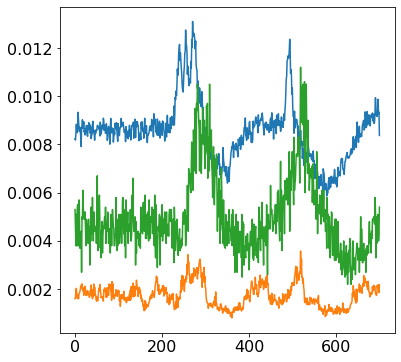

In [145]:
istim = 0
fig, ax = plt.subplots(figsize = (6,6))
for ipop in range(rmat_lpa_w_lgn_fb.shape[-1]):
    fir_rate_plot = rmat_lpa_w_lgn_fb[istim,:,ipop]
    #fir_rate_plot = gaussian_filter1d(fir_rate_plot*1E3, sigma = 2)
    
    ax.plot(fir_rate_plot)

### Add LGN input to model population firing rates

In [105]:
rmat_model_w_lgn = np.zeros((rmat_model.shape[:2]+(rmat_model.shape[-1]+1,)))
rmat_model_w_lgn[:,:,1:] = rmat_model

fir_rate_lgn_input = np.histogram(timestamps_lgn_input, bins = bins_lgn)[0]/17400
fir_rate_lgn_input = fir_rate_lgn_input.reshape((ntrials_sim, trial_dur_sim))
rmat_model_w_lgn[:,:,0] = np.mean(fir_rate_lgn_input[:,t_start:t_stop], axis=0)

AttributeError: 'dict' object has no attribute 'shape'

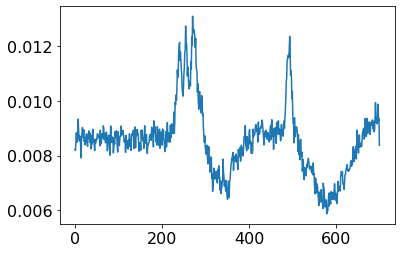

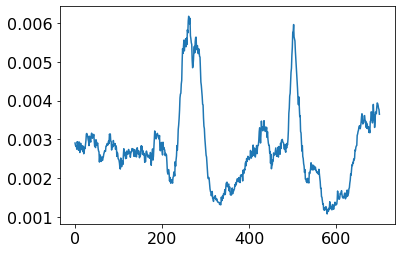

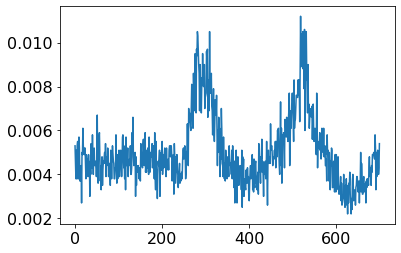

In [146]:
for ipop in range(rmat_model_w_lgn_fb.shape[-1]):
    plt.figure()
    plt.plot(rmat_model_w_lgn_fb[0,:,ipop])

In [81]:
subtract_baseline = True
baseline_presubtracted_lfp = False
if subtract_baseline:
    baseline_end = 200
    baseline_string = 'baseline_subtracted'
else:
    baseline_end = 0
    if baseline_presubtracted_lfp:
        baseline_string = 'baseline_pre_subtracted'
        baseline_end_fir_rates = 250
    else:
        baseline_string = 'w_baseline'

In [82]:
nchan

22

In [83]:
t_kernelParams = [10, 1]
#lb = [np.finfo(np.double).tiny, 0]#, np.finfo(np.double).tiny, 0]
lb = [2,1]
ub = [10, 5]#, 300, 50]

In [86]:
# loading the underlying data matrix and define names
#LOADNAME = 'testdata.mat'
CASENAME = 'lfp_sim_w_LGN_input_and_v1v1_connects_modified'

#DATA = loadmat(LOADNAME)
SETNAME_MUA = 'mua'
SETNAME_LFP = 'lfp'

# MUA = DATA[SETNAME_MUA]
LFP = np.zeros((nstim, ntime, nchan))
CSD = np.zeros((nstim, ntime, nchan))
print(CSD.shape)
for istim in range(CSD.shape[0]):
    LFP[istim] = lfp_for_lpa[istim].T
    CSD[istim] = csd_for_lpa[istim].T
MUA = np.zeros_like(CSD)#MUA[:,t_start:t_stop]

###################################################################
# initializing the LPA_signal

nstim, ntime, nchan = CSD.shape

z_start = 0.   # depth of first electrode in mm
z_space = 0.04  # electrode spacing in mm

S_dict = {
    'mua_data' : MUA,
    'lfp_data' : CSD,
    'dt' : 1,
    'z_start' : z_start,
    'z_space' : z_space,
    'casename' : CASENAME,
    'tstim' : baseline_end,
    'sub_at' : 'base', # 
    'verbose' : True
    }

lpa_signal = LPA_Signal(**S_dict)

####################################################################
# Initial guess

#npop_guess = 4

#pos_pops = np.zeros(3*npop)

#x0 = np.zeros(12)
#x0[:npop] = [0.4, 0.7, 0.95, 1.4] # Lateral position of populations (mm)
#x0[npop:2*npop] = [0.1, 0.1, 0.1, 0.1] # Width of populations
#x0[2*npop:] = [0.1, 0.1, 0.1, 0.1] # Slope of populations

####################################################################
# set up arguments for solving

maxpos = z_start + (nchan - 1) * z_space
maxpopwidth = 0.7
maxslopewidth = z_space

# lower bounds
lb = npop_guess * [z_start]# + 2 * npop_guess * [0]
print('lb = ', lb)
# upper bounds
ub = npop_guess * [maxpos] + npop_guess * [maxpopwidth] # + npop_guess * [maxslopewidth]
print('ub = ', ub)

# put any arguments passed to the initialization of the solver here,
# see documentation for openopt.NLP for details.
init_args = {
     'maxIter' : 10000,
     'maxFunEvals' : 20000,
     'maxTime' : 600,
     'maxCPUTime' : 1000,
     'maxNonSuccess' : 30
    }

# There are also some additional arguments that could be passed to the
# call function of the solver, but most of this will be handled inside
# the call function for lpa_signal (like *x0* and *plot*)
solve_args = {}

# If you subclassed LPA_Signal() and wrote your own error function
# that needs additional arguments, you can put it in the *f_args*
# tuple. Remember that the first argument to the error function is
# always the parameters to be fitted, but this is handled under the
# hood. Only additional (only positional) arguments goes into *f_args*
f_args = ()

#############################################################
# Load results from example1_mua.py

# rmat and MPhi does not belong in lpa_signal, just put it there for
# safekeeping.
#rmat = lpa_signal.rmat
#Mphi = lpa_signal.Mphi
#del lpa_signal.rmat
#del lpa_signal.Mphi


###########################################################
# Set up arguments for solving lfp

# kernel = 'singleExp'
# x0 = [50., 0.1]
# lb = [np.finfo(np.double).tiny, 0]
# ub = [50, 50]

#kernel = 'uniqueKernels'
kernel = 'singleExp'
t_kernelParams = [15, 1]#, 15, 1, 15, 1]
#lb = [np.finfo(np.double).tiny, 0, np.finfo(np.double).tiny, 0]
lb = [5,2]#, 5,2, 5,2]
ub = [30, 10]#, 30, 10, 30, 10]
#ub = [6, 5, 1, 1]
# these dicts are explained in example1_mua.py
#init_args = {}
solve_args = {}

#f_rate_synthNew = np.zeros_like(LFP)
#f_rate_synthNew[:, :600, :] = f_rate_synth[0:1, :, :]
#f_rate_synthNew[:, 600:, :] = f_rate_synth[0:1, :599, :]
#print(f_rate_synthNew)

'''rmat_model = np.zeros_like(rmat_lpa)
for istim in range(rmat_model.shape[0]):
    rmat_model[istim] = np.array(list(fir_rate_all_stim_trial_avg.values())).T'''


use_model_fir_rates = True
include_lgn = True
if use_model_fir_rates:
    if include_lgn:
        rmat = rmat_model_w_lgn_fb
        lgn_string = 'w_lgn_and_fb'
    else:
        rmat = np.zeros((1,) + np.array(list(fir_rate_all_stim_trial_avg.values())).T.shape)
        rmat[0] = np.array(list(fir_rate_all_stim_trial_avg.values())).T
        lgn_string = 'wo_lgn'
    fir_rate_decomp_string = 'decomp_w_mod_fir_rates'
else:
    if include_lgn:
        rmat = rmat_lpa_w_lgn_fb
        lgn_string = 'w_lgn_and_fb'
    else:
        rmat = rmat_lpa
        lgn_string = 'wo_lgn'
    fir_rate_decomp_string = 'decomp_w_lpa_fir_rates'
    
if subtract_baseline:
    for istim in range(rmat.shape[0]):
        rmat[istim] = rmat[istim] - np.mean(rmat[istim,:baseline_end], axis = 0)
        
    
#if np.logical_and(subtract_baseline or baseline_presubtracted_lfp, use_model_fir_rates):
#    for ipop in range(rmat.shape[-1]):
#        for istim in range(rmat.shape[0]):
#            rmat[istim] -= np.mean(rmat[istim,:baseline_end_fir_rates,ipop])

f_args = (rmat, kernel)
###############################################################
# Solve lfp
print('init_args: ', init_args)
solve_dict = {
    'init_args' : init_args,
    'solve_args' : solve_args,
    'f_args' : f_args,
    'plot' : False
    }

mode = 'lfp'
solver = 'de'
pen_fac_dev_from_0 = 0

err_wo_pen_dict = dict()
Cmat_lpa_dict = dict()
Rmat_lpa_dict = dict()
Cphi_lpa_dict = dict()
h_list_dict = dict()

#for pen_fac_dev_from_0 in np.logspace(-4, 4, 17):

r_lpa_LFP, Cmat_lpa, Rmat_lpa, Cphi_lpa, h_list, err_wo_pen = lpa_signal(mode, solver, t_kernelParams, lb, ub, pen_fac = pen_fac_dev_from_0, **solve_dict)

err_wo_pen_dict[pen_fac_dev_from_0] = err_wo_pen


Cmat_lpa_dict[pen_fac_dev_from_0] = Cmat_lpa
Rmat_lpa_dict[pen_fac_dev_from_0] = Rmat_lpa
Cphi_lpa_dict[pen_fac_dev_from_0] = Cphi_lpa
h_list_dict[pen_fac_dev_from_0] = h_list

(2, 700, 22)
This is class *LPA_Signal* in *pyLPA* module
lb =  [0.0]
ub =  [0.84, 0.7]
init_args:  {'maxIter': 10000, 'maxFunEvals': 20000, 'maxTime': 600, 'maxCPUTime': 1000, 'maxNonSuccess': 30}
Solving for lfp part of signal
self.pen_fac:  0
Here

------------------------- OpenOpt 0.5629 -------------------------
problem: unnamed   type: GLP    goal: minimum
solver: de
variables: 2
  iter  objFunVal  
    0  1.818e-01 
   10  1.350e-01 
   20  1.350e-01 
   30  1.350e-01 
   40  1.350e-01 
   50  1.350e-01 
   60  1.350e-01 
   70  1.350e-01 
   80  1.350e-01 
   83  1.350e-01 
istop: 11 (Non-Success Number > maxNonSuccess = 30)
Solver:   Time Elapsed = 1.25  	CPU Time Elapsed = 1.25
objFuncValue: 0.13499509 (feasible, MaxResidual = 0)


In [274]:
err_wo_pen_dict

{0.0001: 0.13661302520245025,
 0.001: 0.1366142959471353,
 0.01: 0.1377171511395397,
 0.1: 0.1903823011760355,
 1.0: 0.23681564813829636,
 10.0: 0.25635634976165633,
 100.0: 0.2563563497616599,
 1000.0: 0.2563563497615178,
 10000.0: 0.2563563497606083}

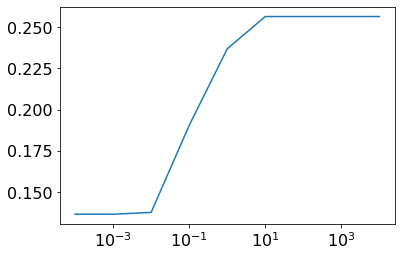

In [275]:
fig, ax = plt.subplots()

ax.plot(np.array(list(err_wo_pen_dict.keys())), np.array(list(err_wo_pen_dict.values())))

ax.set_xscale('log')



In [289]:
np.argmin(Cmat_lpa, axis = 0), np.argmax(Cmat_lpa, axis = 0)
np.argmin(Cmat_lpa, axis = 0)-np.argmax(Cmat_lpa, axis = 0)

array([ -6,  -4, -12])

In [290]:
r_lpa_LFP.ff

22517.168052362933

#### Compute CSD from LPA estimated lfp

In [278]:
applied_to_LFP = False
if applied_to_LFP:
    method='DeltaiCSD'

    Cphi_lpa_est = np.zeros_like(Cphi_lpa)

    for istim in range(Cphi_lpa.shape[0]):
        lfp_temp = Cphi_lpa[istim].T

        csd_temp = compute_csd(lfp_temp, method = 'delta', h = 40*1E-6*pq.m, gauss_filter = (1.4,0),
                            coord_electrodes = np.linspace(0,840E-6, nchan_lim) * pq.m)

        Cphi_lpa_est[istim] = csd_temp.T

    Cphi_lpa = Cphi_lpa_est

In [279]:
r_lpa_LFP.ff

22517.168052362933

In [87]:
pop_names = []
if include_lgn:
    pop_names.append('LGN')

if npop_guess == 4:
    pop_names.append('L2/3')
    pop_names.append('L4')
    pop_names.append('L5')
    pop_names.append('L6')
elif npop_guess == 3:
    pop_names.append('L2/3 and L4')
    pop_names.append('L5')
    pop_names.append('L6')
elif npop_guess == 2:
    pop_names.append('Upper layers')
    pop_names.append('Deep layers')
elif npop_guess == 1:
    pop_names.append('v1')
    
pop_names.append('FB')
pop_names.append('BKG')

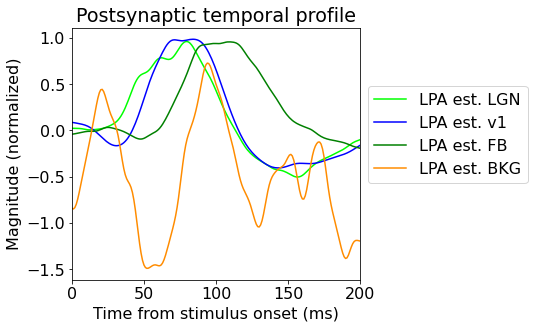

In [88]:
fig, ax = plt.subplots(ncols = 1, nrows =1, figsize = (8, 5))

fig.subplots_adjust(left = 0.15, right = 0.65, bottom = 0.15, top = 0.85)

t = np.arange(ntime)
channel = np.arange(nchan)

pop_colors = ['b', 'g', 'darkorange', 'blueviolet']
pop_colors_w_lgn = ['lime', 'b', 'g', 'darkorange', 'blueviolet']

if include_lgn:
    colors = pop_colors_w_lgn
else:
    colors = pop_colors
    
if Rmat_lpa.shape[-1] == 6:
    colors = ['lime', 'b', 'g', 'r', 'm', 'pink' ]
    pop_names = np.concatenate([pop_names, pop_names])
    
istim = 0
for i in range(Rmat_lpa.shape[-1]):
    fir_rate_lpa_plot = Rmat_lpa[istim,:,i]#[:,stim_onset_mark:stim_onset_mark+100,i]#/rmat_lpa[:,stim_onset_mark:stim_onset_mark+100,:].max()
    if ~subtract_baseline:
        fir_rate_lpa_plot -= np.mean(fir_rate_lpa_plot[100:tstim_onset_sim], axis = 0)
    fir_rate_lpa_plot = fir_rate_lpa_plot/Rmat_lpa[istim,tstim_onset_sim:tstim_onset_sim+201,i].max()
    fir_rate_lpa_plot = gaussian_filter1d(fir_rate_lpa_plot,sigma = 3)
    fir_rate_lpa_plot = fir_rate_lpa_plot[tstim_onset_sim:tstim_onset_sim+201]
    ax.plot(fir_rate_lpa_plot, color = colors[i], label='LPA est. '+pop_names[i])
    #ax[i,0].plot(t, MUA_time[i]*1E3, alpha=0.5, label='ground truth')
    ax.set_xlabel('Time from stimulus onset (ms)')
    ax.set_ylabel('Magnitude (normalized)')
    #ax[1,0].set_ylabel('Magnitude (a. u.)')
    
    #ax[i,1].plot(M[i], channel, alpha=0.5, label='ground truth')
    
    ax.set_title('Postsynaptic temporal profile')
    

ax.margins(x=0)
    
ax.legend(bbox_to_anchor = (1,0.8))

#fig.suptitle('Spatiotemporal decomposition of MUA', y = 0.99, x = 0.45)


fig_name = 'LPA-est-postsyn-temporal-profile-'+str(npop_guess)+'_pops.png'
savepath = os.path.join(fig_dir, baseline_string, str(npop_guess)+'pops', lgn_string, fir_rate_decomp_string, fig_name)
#fig.savefig(savepath, facecolor = 'w')

#### Whole trial

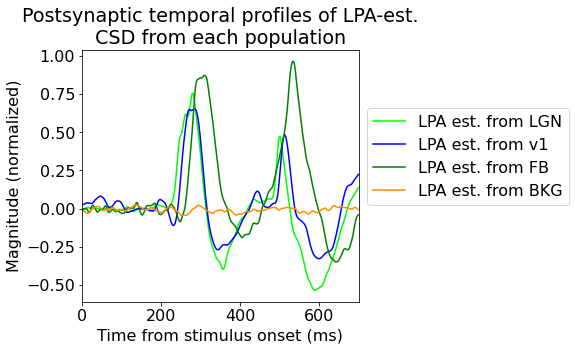

In [89]:
fig, ax = plt.subplots(ncols = 1, nrows =1, figsize = (8, 5))

fig.subplots_adjust(left = 0.15, right = 0.63, bottom = 0.15, top = 0.85)

t = np.arange(ntime)
channel = np.arange(nchan)

pop_colors = ['b', 'g', 'darkorange', 'blueviolet']
pop_colors_w_lgn = ['lime', 'b', 'g', 'darkorange', 'blueviolet']

if include_lgn:
    colors = pop_colors_w_lgn
else:
    colors = pop_colors
    
if Rmat_lpa.shape[-1] == 6:
    colors = ['lime', 'b', 'g', 'r', 'm', 'pink' ]
    pop_names = np.concatenate([pop_names, pop_names])
    
istim = 0
for i in range(Rmat_lpa.shape[-1]):
    fir_rate_lpa_plot = Rmat_lpa[istim,:,i]#[:,stim_onset_mark:stim_onset_mark+100,i]#/rmat_lpa[:,stim_onset_mark:stim_onset_mark+100,:].max()
    if ~subtract_baseline:
        fir_rate_lpa_plot -= np.mean(fir_rate_lpa_plot[100:tstim_onset_sim], axis = 0)
    fir_rate_lpa_plot = fir_rate_lpa_plot/Rmat_lpa[istim, :,:].max()
    fir_rate_lpa_plot = gaussian_filter1d(fir_rate_lpa_plot,sigma = 3)
    fir_rate_lpa_plot = fir_rate_lpa_plot[:]
    ax.plot(fir_rate_lpa_plot, color = colors[i], label='LPA est. from '+pop_names[i])
    #ax[i,0].plot(t, MUA_time[i]*1E3, alpha=0.5, label='ground truth')
    ax.set_xlabel('Time from stimulus onset (ms)')
    ax.set_ylabel('Magnitude (normalized)')
    #ax[1,0].set_ylabel('Magnitude (a. u.)')
    
    #ax[i,1].plot(M[i], channel, alpha=0.5, label='ground truth')
    
    ax.set_title('Postsynaptic temporal profiles of LPA-est.\nCSD from each population')
    

ax.margins(x=0)
    
ax.legend(bbox_to_anchor = (1,0.8))

#fig.suptitle('Spatiotemporal decomposition of MUA', y = 0.99, x = 0.45)


fig_name = 'LPA-est-postsyn-temporal-profile-'+str(npop_guess)+'_pops.png'
#savepath = os.path.join(fig_dir, baseline_string, str(npop_guess)+'pops', lgn_string, fir_rate_decomp_string, fig_name)
savepath = os.path.join(fig_dir, 'for_Allen_call_Mar_2023', fig_name)
#fig.savefig(savepath, facecolor = 'w')

In [90]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

NameError: name 'iplot' is not defined

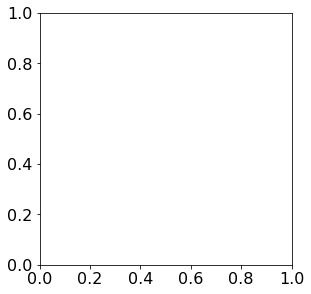

In [91]:
fig, ax = plt.subplots(ncols = 1, figsize = (5,5), sharex = True)

fig.subplots_adjust(left = 0.15, right = 0.85, bottom = 0.15, top = 0.85)

    

ax.plot(h_list[iplot]/h_list[iplot].max())

#ax.set_title('for '+kernel_names[iplot])
ax.set_title('Single synaptic\ntransmission kernel')

ax.set_xlabel('Time (ms)')

fig_name = 'single_kernel.png'

savepath = os.path.join(fig_dir, fir_rate_decomp_string)

if not os.path.exists(savepath):
    os.mkdir(savepath)

savepath = os.path.join(savepath, fig_name)
    

#fig.savefig(savepath, facecolor = 'w')

#ax.hlines(y = 1/np.exp(1), xmin = 5, xmax = 37, color = 'r')

No handles with labels found to put in legend.


0


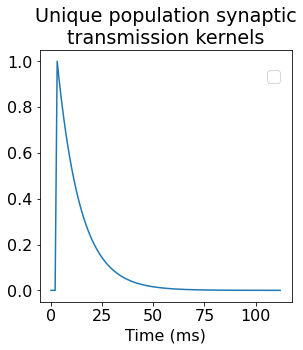

In [127]:
fig, ax = plt.subplots(ncols = 1, figsize = (5,5))

fig.subplots_adjust(left = 0.15, right = 0.85, bottom = 0.15, top = 0.85)

kernel_names = ['LGN', 'V1', 'FB']

for iplot in range(len(h_list)):
    print(iplot)

    ax.plot(h_list[iplot]/h_list[iplot].max())#, label = 'for '+kernel_names[iplot], color = pop_colors_w_lgn[iplot])

    ax.set_title('Unique population synaptic\ntransmission kernels')

    ax.set_xlabel('Time (ms)')

    fig_name = 'kernels.png'

    savepath = os.path.join(fig_dir, fir_rate_decomp_string)
    
    if not os.path.exists(savepath):
        os.mkdir(savepath)
                            
    savepath = os.path.join(savepath, fig_name)
    
fig.legend(bbox_to_anchor = (0.8,0.8))
    

fig.savefig(savepath, facecolor = 'w')

#ax.hlines(y = 1/np.exp(1), xmin = 5, xmax = 37, color = 'r')

LGN -1.2650670471181356 6
v1 0.11370886087049192 5
FB 1.0764195772124991 12
LGN -0.3811837192487817 5


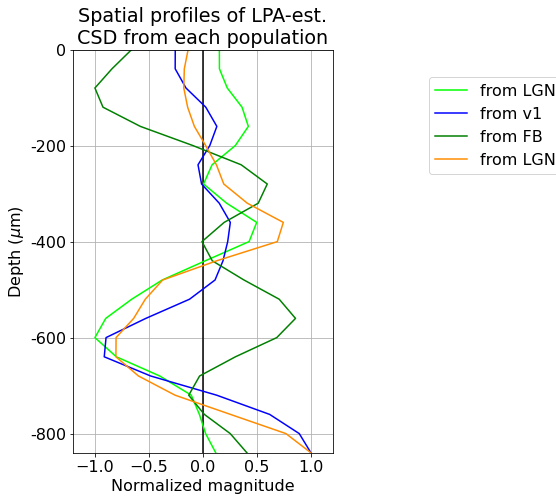

In [93]:
fig, ax = plt.subplots(figsize = (8,8))

if include_lgn:
    colors = pop_colors_w_lgn
else:
    colors = pop_colors

fig.subplots_adjust(left = 0.15, right = 0.6, bottom = 0.15, top = 0.85)
for ipop in range(Cmat_lpa.shape[-1]):
    spat_prof_lpa_pop = Cmat_lpa[:,ipop]
    spat_prof_lpa_pop_plot = spat_prof_lpa_pop/np.abs(spat_prof_lpa_pop).max()
    
    print(pop_names[ipop % (npop_guess+2)], spat_prof_lpa_pop_plot.sum(), abs(np.argmin(spat_prof_lpa_pop_plot)-np.argmax(spat_prof_lpa_pop_plot)))
    
    ax.plot(spat_prof_lpa_pop_plot, channel[:nchan_lim], color = pop_colors_w_lgn[ipop], label = 'from '+pop_names[ipop % (npop_guess+2)])#, color = colors[ipop % (npop_guess+2)])
    
ax.set_ylabel('Depth ($\mu$m)')
ax.set_yticks(np.arange(0,20+5,5))
ax.set_yticklabels(-np.arange(0,1000+200,200))

ax.vlines(x = 0, ymin = 0, ymax = nchan_lim)
ax.set_ylim([0,21])
ax.set_xlabel('Normalized magnitude')
    
ax.set_xlim([-1.2, 1.2])
ax.invert_yaxis()
ax.grid()
fig.legend(bbox_to_anchor = (0.99,0.75))

ax.set_title('Spatial profiles of LPA-est.\nCSD from each population')

fig_name = 'spatial_profile_LPA-est_CSD_pops.png'

savepath = os.path.join(fig_dir, fir_rate_decomp_string)
    
if not os.path.exists(savepath):
    os.mkdir(savepath)

savepath = os.path.join(savepath, fig_name)

#fig.savefig(savepath, facecolor = 'w')

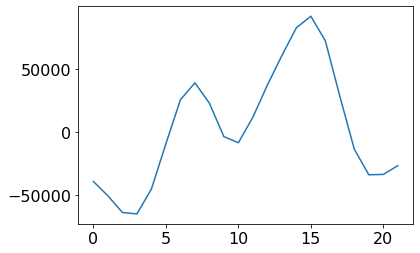

In [287]:

plt.plot(Cmat_lpa[:,ipop])

In [227]:
np.abs(Cmat_lpa.sum(axis = 0)*1E-6).sum()

0.28027287465863243

In [208]:
r_lpa_LFP.ff-np.abs(Cmat_lpa.sum(axis = 0)*1E-6).sum()

0.24142711742184025

In [210]:
csd_sims.keys()

dict_keys(['2022_jan_07', '2022_jan_07_black'])

In [95]:
all_sim_names = ['2022_jan_07', 
                 '2022_jan_07_black', 
                 'ns_2022_jan_07_config', 
                 'gabors_2022_jan_07_config', 
                 'dg_2022_jan_07_config']

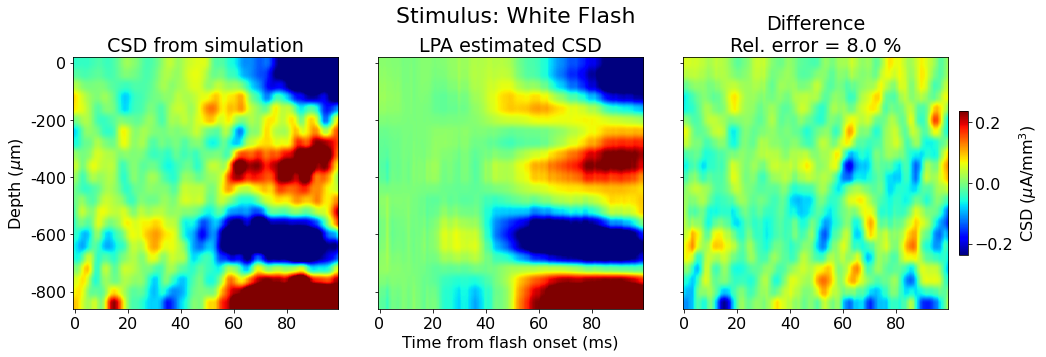

In [96]:
fig, axes = plt.subplots(ncols = 3, figsize = (15, 5), sharex = True, sharey = True)
fig.subplots_adjust(wspace = 0.15, left = 0.08, right = 0.89, bottom = 0.15, top = 0.85)

scale_to_uA = 1E-3

sim_name = '2022_jan_07_shift'
istim = 0



ax = axes[0]
csd_orig_plot = csd_sims[sim_name]
csd_orig_plot = (csd_orig_plot.T-np.mean(csd_orig_plot[:,:tstim_onset_sim], axis = 1)).T
csd_orig_plot = csd_orig_plot[:,tstim_onset_sim:tstim_onset_sim+100]*scale_to_uA
cmap_range = np.abs(csd_orig_plot).max()/3
ax.imshow(csd_orig_plot, cmap = 'jet', aspect='auto', vmin = -cmap_range, vmax = cmap_range)

ax.set_ylabel('Depth ($\mu$m)')
ax.set_yticks(np.arange(0,25+5,5))
ax.set_yticklabels(-np.arange(0,1000+200,200))

ax.set_title('CSD from simulation')

ax = axes[1]
for isim, sim_name_temp in enumerate(all_sim_names):
    if sim_name == sim_name_temp:
        break
'''csd_lpa_plot = csd_lpa[:,tstim_onset_sim:tstim_onset_sim+101]'''
#csd_lpa_plot = (Cphi_lpa[isim].T)#.T-np.mean(csd_lpa[:,:tstim_onset_sim], axis = 1)).T
csd_lpa_plot = (Cphi_lpa[istim]-np.mean(Cphi_lpa[istim,:tstim_onset_sim], axis = 0)).T
csd_lpa_plot = csd_lpa_plot[:,tstim_onset_sim:tstim_onset_sim+100]*scale_to_uA

#cmap_range = np.abs(MUA_synth).max()/2
ax.imshow(csd_lpa_plot, cmap = 'jet', aspect='auto', vmin = -cmap_range, vmax = cmap_range)

ax.set_title('LPA estimated CSD')

ax.set_xlabel('Time from flash onset (ms)')

diff = csd_lpa_plot-csd_orig_plot.magnitude
rel_MSE = np.sum(diff**2)/np.sum(csd_orig_plot.magnitude**2)

ax = axes[2]
#cmap_range = np.abs(MUA_synth).max()/2
im =ax.imshow(diff, cmap = 'jet', aspect='auto', vmin = -cmap_range, vmax = cmap_range)
ax.set_title('Difference\nRel. error = '+str(np.round(rel_MSE*100,1))+' %')

#ax.set_xticks(np.arange(0,100+20,20))
#ax.set_xticklabels(np.arange(0,100+20,20))
#ax.set_xlim([0,100])

fig.suptitle('Stimulus: White Flash', y = 0.99, x = 0.49, fontsize = 22)

cbaxes = fig.add_axes([0.9,0.30,0.008, 0.4])
cb = fig.colorbar(im, ax = ax, cax = cbaxes)
cb.set_label('CSD ($\mu$A/mm$^3$)')

fig_name = 'csd_total_compare_sim_and_LPA_'+sim_name+'.png'
savepath = os.path.join(fig_dir, fir_rate_decomp_string)
    
if not os.path.exists(savepath):
    os.mkdir(savepath)

savepath = os.path.join(savepath, fig_name)
#fig.savefig(savepath, facecolor = 'w')

In [176]:
Cphi_lpa.shape[0]

2

In [424]:
fir_rate_decomp_string

'decomp_w_mod_fir_rates'

In [425]:
savepath = os.path.join('LPA_estimates', 'w_feedback', baseline_string, 'decomp_w_model_fir_rates', lgn_string, str(npop_guess)+'_pops', 'unconstrained', 
                       'opt_on_csd', 'opt_on_'+str(Cphi_lpa.shape[0])+'_stim', 'flash')
for ipath_part, path_part in enumerate(savepath.split('/')):
    if ipath_part == 0:
        path = path_part
    else:
        path = os.path.join(path, path_part)
    
    if not os.path.exists(path):
        os.mkdir(path)

#### Save

In [461]:
Cphi_lpa.shape

(2, 700, 22)

In [462]:
savepath = os.path.join('LPA_estimates', 'w_feedback', baseline_string, 'decomp_w_model_fir_rates', lgn_string, str(npop_guess)+'_pops', 'unconstrained', 
                       'opt_on_csd', 'opt_on_'+str(Cphi_lpa.shape[0])+'_stim', 'flash')
for ipath_part, path_part in enumerate(savepath.split('/')):
    if ipath_part == 0:
        path = path_part
    else:
        path = os.path.join(path, path_part)
    
    if not os.path.exists(path):
        os.mkdir(path)

In [463]:
#filename = 'LFP_est_both_flash_and_drift_gratings.npy'
filename = 'csd_total.npy'

savepath = os.path.join('LPA_estimates', 'w_feedback', baseline_string, 'decomp_w_model_fir_rates', lgn_string, str(npop_guess)+'_pops', 'unconstrained', 
                       'opt_on_csd', 'opt_on_'+str(Cphi_lpa.shape[0])+'_stim', 'flash')

savepath = os.path.join(savepath, filename)

#np.save(savepath, Cphi_lpa)

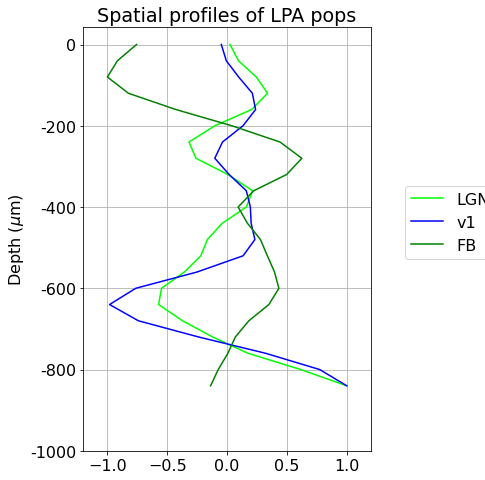

In [464]:
fig, ax = plt.subplots(figsize = (7,7))

fig.subplots_adjust(left = 0.2, right = 0.77, bottom = 0.08, top = 0.92)

if include_lgn:
    colors = pop_colors_w_lgn
else:
    colors = pop_colors

for ipop in range(Cmat_lpa.shape[-1]):
    spat_prof_lpa_pop = Cmat_lpa[:,ipop]
    spat_prof_lpa_pop_plot = spat_prof_lpa_pop/np.abs(spat_prof_lpa_pop).max()
    
    ax.plot(spat_prof_lpa_pop_plot, channel, color = colors[ipop], label = pop_names[ipop])
    
ax.set_xlim([-1.2, 1.2])
ax.invert_yaxis()
ax.grid()
ax.set_ylabel('Depth ($\mu$m)')
ax.set_yticks(np.arange(0,25+5,5))
ax.set_yticklabels(-np.arange(0,1000+200,200))
ax.set_title('Spatial profiles of LPA pops')

fig.legend(bbox_to_anchor = (1.0, 0.6))

fig_name = 'spatial_profiles_LFP_pops_w_LPA.png'
savepath = os.path.join(fig_dir, baseline_string, str(npop_guess)+'pops', lgn_string, fir_rate_decomp_string, fig_name)



#fig.savefig(savepath, facecolor = 'w')

In [97]:
csd_lpa_pop_recon = np.zeros((Rmat_lpa.shape[0], Rmat_lpa.shape[2], Cmat_lpa.shape[0], Rmat_lpa.shape[1]))

csd_lpa_dict = dict()
for istim, sim_name in enumerate(csd_sims.keys()):
    csd_lpa_pops_dict = dict()
    for ipop in range(Cmat_lpa.shape[-1]):

        csd_lpa_pop_recon[istim, ipop] = np.outer(Cmat_lpa[:,ipop], Rmat_lpa[istim,:,ipop])
        
        pop_name = pop_names[ipop % (npop_guess+2)]
        
        csd_lpa_pops_dict[pop_name] = csd_lpa_pop_recon[istim,ipop]
        
    csd_lpa_dict[sim_name] = csd_lpa_pops_dict

In [98]:
csd_lpa_pop_recon.shape

(2, 4, 22, 700)

In [99]:
applied_to_LFP = False
if applied_to_LFP:
    method='DeltaiCSD'

    csd_lpa_pop_recon_est = np.zeros_like(csd_lpa_pop_recon)

    for istim in range(csd_lpa_pop_recon.shape[0]):
        for ipop in range(csd_lpa_pop_recon.shape[1]):
            lfp_temp = csd_lpa_pop_recon[istim, ipop]

            csd_temp = compute_csd(lfp_temp, method = 'delta', h = 40*1E-6*pq.m, gauss_filter = (1.4,0),
                                coord_electrodes = np.linspace(0, 840*1E-6, nchan_lim) * pq.m)

            csd_lpa_pop_recon_est[istim, ipop] = csd_temp

    csd_lpa_pop_recon = csd_lpa_pop_recon_est

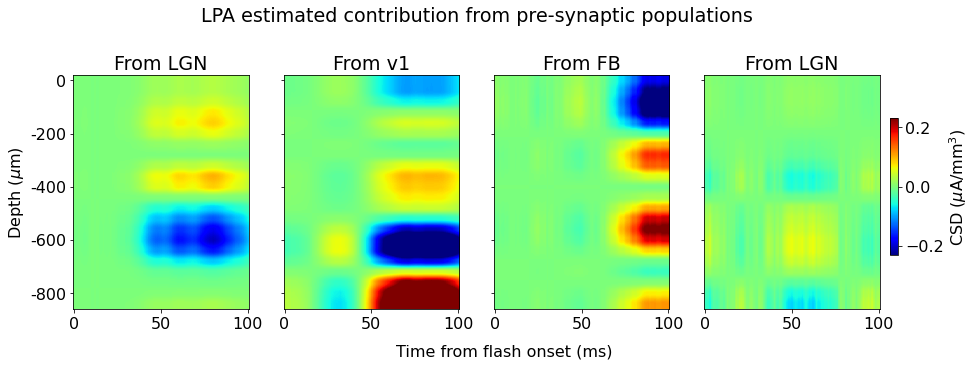

In [100]:
fig, axes = plt.subplots(ncols = csd_lpa_pop_recon.shape[1], figsize = (7*(npop_guess+1), 5), sharex = True, sharey = True)
fig.subplots_adjust(left = 0.1, right = 0.9, bottom = 0.15, top = 0.8)

scale_to_uA = 1E-3
cmap_range = np.abs(csd_lpa_pop_recon).max()/3*scale_to_uA
istim = 0
for ipop in range(csd_lpa_pop_recon.shape[1]):
    ax = axes[ipop]
    
    if ipop == 0:
        ax.set_ylabel('Depth ($\mu$m)')
        ax.set_yticks(np.arange(0,25+5,5))
        ax.set_yticklabels(-np.arange(0,1000+200,200))
        
    
        
    
    csd_lpa_pops_plot = csd_lpa_pop_recon[istim, ipop].copy()
    
    ax.set_title('From '+pop_names[ipop % (npop_guess+2)])
    
    #for ichan in range(csd_lpa_pops_plot.shape[0]):
    #    csd_lpa_pops_plot[ichan] = csd_lpa_pops_plot[ichan]-np.mean(csd_lpa_pops_plot[ichan,:tstim_onset_sim])
    
    #im = ax.imshow(csd_lpa_pops_plot[:,tstim_onset_sim:tstim_onset_sim+200]*scale_to_mA, cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')
    im = ax.imshow(csd_lpa_pops_plot[:,tstim_onset_sim:tstim_onset_sim+101]*scale_to_mA, cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')
    
#ax.set_xticks(np.arange(0,100+20,20))
#ax.set_xticklabels(np.arange(0,100+20,20))
#ax.set_xlim([0,100])
plt.figtext(s = 'Time from flash onset (ms)', x = 0.42, y = 0.02)

cbaxes = fig.add_axes([0.91,0.30,0.008, 0.38])
cb = fig.colorbar(im, ax = ax, cax = cbaxes)
cb.set_label('CSD ($\mu$A/mm$^3$)')

fig.suptitle('LPA estimated contribution from pre-synaptic populations', y = 0.99)

fig_name = 'csd_pre-syn_pop_contributions.png'
savepath = os.path.join(fig_dir, fir_rate_decomp_string)
    
if not os.path.exists(savepath):
    os.mkdir(savepath)

savepath = os.path.join(savepath, fig_name)
#fig.savefig(savepath, facecolor = 'w')

## Load GT population contributions

In [101]:
#config_name = '2021_dec_16_config'
config_name = '2022_jan_07_config'

### Total CSD generated by LGN input alone

In [102]:
filename = 'csd_total_lgn.npy'
loadpath = os.path.join('..', 'ground_truth', 'replay_w_cut_sims', config_name, filename)
csd_sims_gt = np.load(loadpath, allow_pickle=True)[()]

In [103]:
csd_sims_gt.keys()

dict_keys(['2021_dec_16_all_active_only_LGN_w_cut'])

### Layers contributions to CSD from LGN input alone

In [104]:
filename = 'csd_layers_lgn.npy'
loadpath = os.path.join('..', 'ground_truth', 'replay_w_cut_sims', config_name, filename)
csd_sims_layers_gt = np.load(loadpath, allow_pickle=True)[()]

In [105]:
csd_sims_layers_gt.keys()

dict_keys(['2021_dec_16_all_active_only_LGN_w_cut'])

### FB

In [106]:
filename = 'csd_total_fb.npy'
loadpath = os.path.join('..', 'ground_truth', 'replay_w_cut_sims', config_name, filename)
csd_sims_gt_temp = np.load(loadpath, allow_pickle=True)[()]

for sim_name in csd_sims_gt_temp.keys():
    csd_sims_gt[sim_name] = csd_sims_gt_temp[sim_name]

In [107]:
csd_sims_gt_temp.keys()

dict_keys(['2022_jan_07_fb_only_no_bkg'])

In [108]:
csd_sims_gt.keys()

dict_keys(['2021_dec_16_all_active_only_LGN_w_cut', '2022_jan_07_fb_only_no_bkg'])

In [189]:
filename = 'csd_layers_fb.npy'
loadpath = os.path.join('..', 'ground_truth', 'replay_w_cut_sims', config_name, filename)
csd_sims_layers_gt_temp = np.load(loadpath, allow_pickle=True)[()]

for sim_name in csd_sims_layers_gt_temp.keys():
    csd_sims_layers_gt[sim_name] = csd_sims_layers_gt_temp[sim_name]

In [109]:
csd_sims_layers_gt_temp.keys()

NameError: name 'csd_sims_layers_gt_temp' is not defined

In [110]:
csd_sims_layers_gt.keys()

dict_keys(['2021_dec_16_all_active_only_LGN_w_cut'])

In [111]:
filename = 'csd_total.npy'
loadpath = os.path.join('..', 'ground_truth', 'replay_w_cut_sims', config_name, filename)

csd_sims_gt_temp = np.load(loadpath, allow_pickle=True)[()]

for sim_name in csd_sims_gt_temp.keys():
    csd_sims_gt[sim_name] = csd_sims_gt_temp[sim_name]


In [112]:
csd_sims_gt_temp.keys()

dict_keys(['2022_jan_07_replay_recurr_L1_w_cut', '2022_jan_07_replay_recurr_L23_w_cut', '2022_jan_07_replay_recurr_L4_w_cut', '2022_jan_07_replay_recurr_L5_w_cut', '2022_jan_07_replay_recurr_L6_w_cut'])

In [113]:
csd_sims_gt_temp[sim_name]['trial_avg'].shape

(26, 700)

In [114]:
csd_sims_gt.keys()

dict_keys(['2021_dec_16_all_active_only_LGN_w_cut', '2022_jan_07_fb_only_no_bkg', '2022_jan_07_replay_recurr_L1_w_cut', '2022_jan_07_replay_recurr_L23_w_cut', '2022_jan_07_replay_recurr_L4_w_cut', '2022_jan_07_replay_recurr_L5_w_cut', '2022_jan_07_replay_recurr_L6_w_cut'])

In [115]:
filename = 'csd_layers.npy'
loadpath = os.path.join('..', 'ground_truth', 'replay_w_cut_sims', config_name, filename)
csd_sims_layers_gt_temp = np.load(loadpath, allow_pickle=True)[()]

for sim_name in csd_sims_layers_gt_temp.keys():
    csd_sims_layers_gt[sim_name] = csd_sims_layers_gt_temp[sim_name]

In [116]:
csd_sims_layers_gt.keys()

dict_keys(['2021_dec_16_all_active_only_LGN_w_cut', '2022_jan_07_replay_recurr_L1_w_cut', '2022_jan_07_replay_recurr_L23_w_cut', '2022_jan_07_replay_recurr_L4_w_cut', '2022_jan_07_replay_recurr_L5_w_cut', '2022_jan_07_replay_recurr_L6_w_cut'])

In [117]:
csd_sims_gt_v1_summed.keys()

NameError: name 'csd_sims_gt_v1_summed' is not defined

In [118]:

csd_gt_sum_v1_all_trials_temp = np.zeros_like(csd_sims_gt[sim_name]['all_trials'])
csd_gt_sum_v1_trial_avg_temp = np.zeros_like(csd_sims_gt[sim_name]['trial_avg'])
for sim_name in csd_sims_gt.keys():
    if 'LGN' not in sim_name and '2022_jan_07_fb_only_no_bkg' not in sim_name:
        csd_gt_sum_v1_all_trials_temp += csd_sims_gt[sim_name]['all_trials']
        csd_gt_sum_v1_trial_avg_temp += csd_sims_gt[sim_name]['trial_avg']
    
csd_sims_gt_sum_v1_temp = dict()
csd_sims_gt_sum_v1_temp['all_trials'] = csd_gt_sum_v1_all_trials_temp
csd_sims_gt_sum_v1_temp['trial_avg'] = csd_gt_sum_v1_trial_avg_temp

csd_sims_gt_v1_summed = dict()
csd_sims_gt_v1_summed['LGN'] = csd_sims_gt['2021_dec_16_all_active_only_LGN_w_cut']
csd_sims_gt_v1_summed['v1'] = csd_sims_gt_sum_v1_temp
csd_sims_gt_v1_summed['feedback'] = csd_sims_gt['2022_jan_07_fb_only_no_bkg']

In [119]:
ytick_step = 5
yticks = np.arange(0,26,ytick_step)
ylabel_start = 0
ylabel_stop = 1000
ytick_label_step = int((ylabel_stop-ylabel_start)/ytick_step)
ytick_labels = -np.arange(ylabel_start, ylabel_stop+ytick_label_step, ytick_label_step)

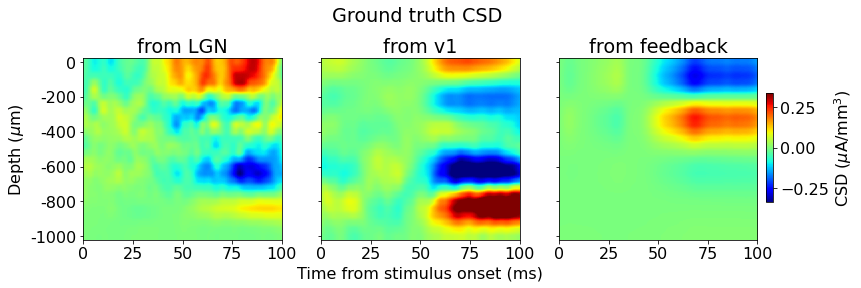

In [120]:
fig, axes = plt.subplots(nrows = 1, ncols = npop_guess+2, figsize = (6*(npop_guess+1),4), sharex = True, sharey = True)
    
fig.subplots_adjust(hspace = 0.4, left = 0.1, right = 0.88, bottom = 0.17, top = 0.8)

tstim_onset = 200

for isim, sim_name in enumerate(csd_sims_gt_v1_summed.keys()):
    csd_sim = csd_sims_gt_v1_summed[sim_name]['trial_avg'][:,tstim_onset:tstim_onset+101]*scale_to_uA
    
    if 'LGN' not in sim_name:
        csd_sim = gaussian_filter(csd_sim, sigma = (1.4,0))
    
    irow = isim // 5 + 1
    icol = isim % 5

    ax = axes[icol]
        
    
    if isim == 0:
        cmap_range = np.abs(csd_sim).max()
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        ax.set_ylabel('Depth ($\mu$m)')
    
    im = ax.imshow(csd_sim, cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')
    
    if isim == 0:
        #ax.set_yticks(yticks)
        #ax.set_yticklabels(ytick_labels)
        ax.set_ylabel('Depth ($\mu$m)')
    elif isim == 1:
        ax.set_xlabel('Time from stimulus onset (ms)')
        
    #ax.set_xticks(xticks)
    #ax.set_xticklabels(xticks_labels)
    
    #cb = fig.colorbar(im, ax = ax)
    
    #title_from_pop_name = sim_name.split('_')[-3]
    #ax.set_title('from '+title_from_pop_name)
    
    ax.set_title('from '+sim_name)
    
    fig.suptitle('Ground truth CSD ', y = 0.98, x = 0.49)
    
cbaxes = fig.add_axes([0.89,0.30,0.008, 0.38])
cb = fig.colorbar(im, ax = ax, cax = cbaxes)
cb.set_label('CSD ($\mu$A/mm$^3$)')
    
ax.set_xlim([0, csd_sim.shape[1]-1])

cb.set_label('CSD ($\mu$A/mm$^3$)')

fig_name = 'csd_pop_contribs_flash_common_scale_'+config_name+'.png'

savepath = os.path.join(fig_dir, fir_rate_decomp_string)
    
if not os.path.exists(savepath):
    os.mkdir(savepath)

savepath = os.path.join(savepath, fig_name)

#fig.savefig(savepath, facecolor = 'w')

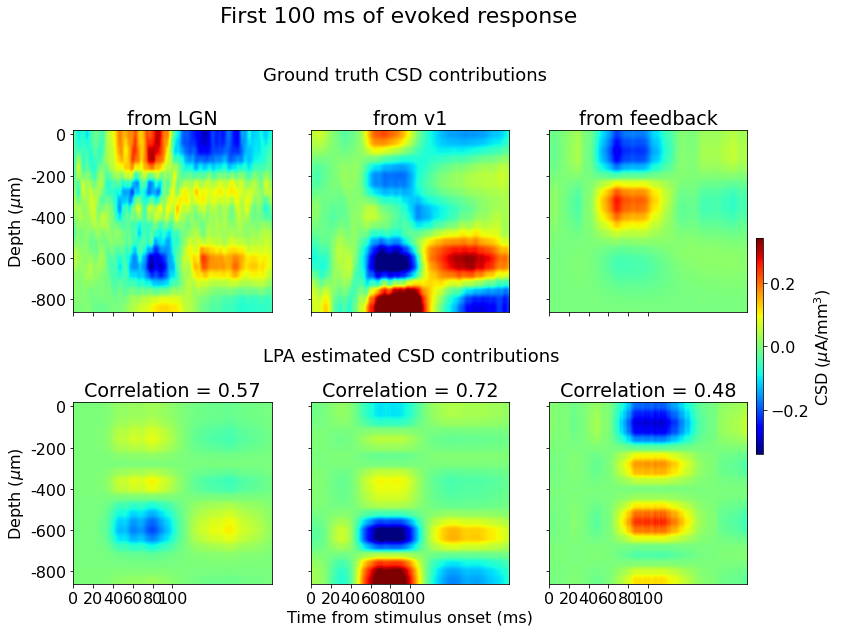

In [134]:
fig, axes = plt.subplots(nrows = 2, ncols = npop_guess+2, figsize = (6*(npop_guess+1),10), sharex = True, sharey = True)
    
tstim_onset = 200
scale_to_uA = 1E-3

for isim, sim_name in enumerate(csd_sims_gt_v1_summed.keys()):
    csd_sim = csd_sims_gt_v1_summed[sim_name]['trial_avg'][:nchan_lim,tstim_onset:tstim_onset+201]*scale_to_uA
    
    if 'LGN' not in sim_name:
        csd_sim = gaussian_filter(csd_sim, sigma = (1.4,0))
    
    icol = isim % 3

    ax = axes[0, icol]

    if icol == 0:
        cmap_range = np.abs(csd_sim).max()
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        ax.set_ylabel('Depth ($\mu$m)')
    
    im = ax.imshow(csd_sim, cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')
    
    ax.set_title('from '+sim_name)
    
    if isim == 0:
        #ax.set_yticks(yticks)
        #ax.set_yticklabels(ytick_labels)
        ax.set_ylabel('Depth ($\mu$m)')
        
    
            
    csd_lpa_pop_est = csd_lpa_pop_recon[istim, isim, :nchan_lim, tstim_onset:tstim_onset+201]*scale_to_uA
    
    ax = axes[1, icol]
    
    if icol == 0:
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        ax.set_ylabel('Depth ($\mu$m)')
    
    ax.imshow(csd_lpa_pop_est, cmap = 'jet', aspect = 'auto', vmin = -cmap_range, vmax = cmap_range)
    
    if isim == 1:
        ax.set_xlabel('Time from stimulus onset (ms)')
        
    corr = np.corrcoef(csd_sim.flatten(), csd_lpa_pop_est.flatten())[0,1]
    
    ax.set_title('Correlation = '+str(np.round(corr,2)))

        
    #ax.set_xticks(xticks)
    #ax.set_xticklabels(xticks_labels)
    
    #cb = fig.colorbar(im, ax = ax)
    
    #title_from_pop_name = sim_name.split('_')[-3]
    #ax.set_title('from '+title_from_pop_name)
    
ax.set_xticks(np.arange(0,120,20))

plt.figtext(s = 'First 100 ms of evoked response', x = 0.27, y = 0.95, fontsize = 22)
    
plt.figtext(s = 'Ground truth CSD contributions', x = 0.32, y = 0.87, fontsize = 18)

plt.figtext(s = 'LPA estimated CSD contributions',  x = 0.32, y = 0.48, fontsize = 18)

fig.subplots_adjust(hspace = 0.5, left = 0.1, right = 0.88, bottom = 0.17, top = 0.8)
    
cbaxes = fig.add_axes([0.89,0.35,0.008, 0.3])
cb = fig.colorbar(im, ax = ax, cax = cbaxes)
cb.set_label('CSD ($\mu$A/mm$^3$)')
    
ax.set_xlim([0, csd_sim.shape[1]-1])

cb.set_label('CSD ($\mu$A/mm$^3$)')

fig_name = 'csd_pop_contribs_flash_common_scale_'+config_name+'_w_corr.png'

savepath = os.path.join(fig_dir, fir_rate_decomp_string)
    
if not os.path.exists(savepath):
    os.mkdir(savepath)

savepath = os.path.join(savepath, fig_name)

#fig.savefig(savepath, facecolor = 'w')

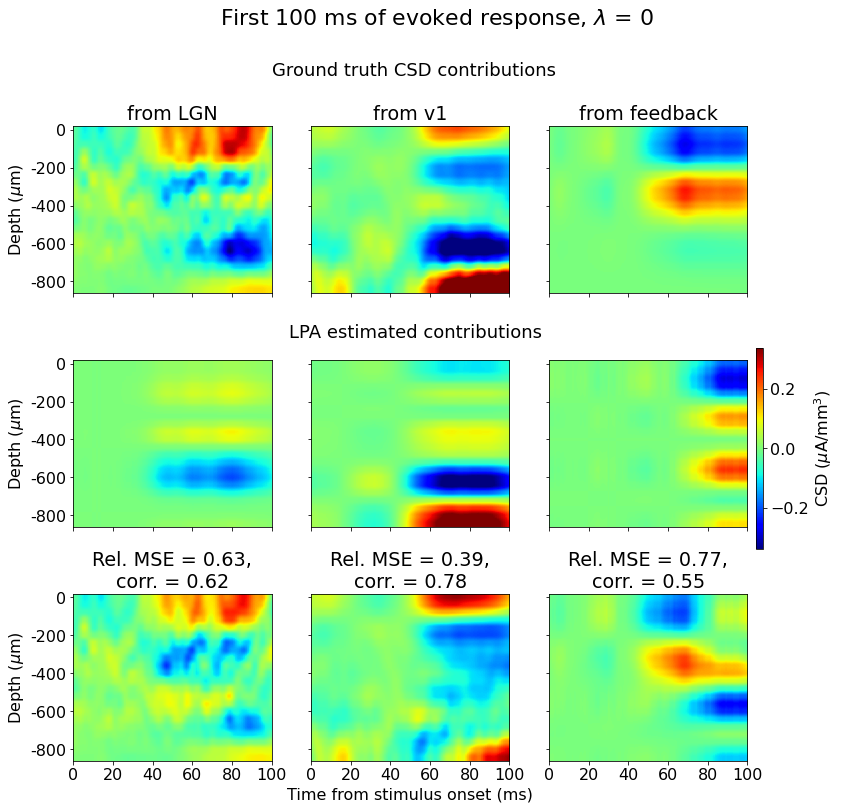

In [125]:
istim = 0
fig, axes = plt.subplots(nrows = 3, ncols = npop_guess+2, figsize = (6*(npop_guess+1),14), sharex = True, sharey = True)

fig.subplots_adjust(hspace = 0.4, left = 0.1, right = 0.88, bottom = 0.17, top = 0.8)

tstim_onset = 200
scale_to_uA = 1E-3

rel_MSE_pops = dict()
corr_pops = dict()

for isim, sim_name in enumerate(csd_sims_gt_v1_summed.keys()):
    csd_sim = csd_sims_gt_v1_summed[sim_name]['trial_avg'][:nchan_lim,tstim_onset:tstim_onset+101]*scale_to_uA

    if 'LGN' not in sim_name:
        csd_sim = gaussian_filter(csd_sim, sigma = (1.4,0))

    csd_lpa_pop_est = csd_lpa_pop_recon[istim, isim, :, tstim_onset:tstim_onset+101]*scale_to_uA

    diff_csd = csd_sim - csd_lpa_pop_est

    rel_MSE = (diff_csd**2).sum()/(csd_sim**2).sum()

    rel_MSE_pops[sim_name] = rel_MSE


    corr = np.corrcoef(csd_sim.flatten(), csd_lpa_pop_est.flatten())[0,1]
    corr_pops[sim_name] = corr


    icol = isim % 3

    ax = axes[0, icol]
    if icol == 0:
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        ax.set_ylabel('Depth ($\mu$m)')

    if isim == 0:
        cmap_range = np.abs(csd_sim).max()

    im = ax.imshow(csd_sim, cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')

    ax.set_title('from '+sim_name)

    csd_lpa_pop_est = csd_lpa_pop_recon[istim, isim, :, tstim_onset:tstim_onset+101]*scale_to_uA

    ax = axes[1, icol]

    if icol == 0:
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        ax.set_ylabel('Depth ($\mu$m)')

    ax.imshow(csd_lpa_pop_est, cmap = 'jet', aspect = 'auto', vmin = -cmap_range, vmax = cmap_range)


    diff_csd = csd_sim - csd_lpa_pop_est

    rel_MSE = (diff_csd**2).sum()/(csd_sim**2).sum()

    RMSE = np.sqrt(((diff_csd**2).sum()/len(diff_csd))/(csd_sim**2).sum())

    RRMSE = np.sqrt(((diff_csd**2).sum()/len(diff_csd)))/np.sqrt((csd_sim**2).sum()/len(diff_csd))

    corr = np.corrcoef(csd_sim.flatten(), csd_lpa_pop_est.flatten())[0,1]

    ax = axes[2, icol]

    if icol == 0:
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        ax.set_ylabel('Depth ($\mu$m)')

    if icol == 1:
        ax.set_xlabel('Time from stimulus onset (ms)')

    ax.imshow(diff_csd, cmap = 'jet', aspect = 'auto', vmin = -cmap_range, vmax = cmap_range)

    ax.set_title('Rel. MSE = '+str(np.round(rel_MSE,2))+',\ncorr. = '+str(np.round(corr,2)))

    #ax.set_xticks(xticks)
    #ax.set_xticklabels(xticks_labels)

#corr_pops_pen_dict[pen_fac] = corr_pops
#rel_MSE_pops_pen_dict[pen_fac] = rel_MSE_pops

ax.set_xticks(np.arange(0,120,20))

plt.figtext(s = 'First 100 ms of evoked response, $\lambda$ = '+str(0), x = 0.27, y = 0.9, fontsize = 22)

plt.figtext(s='Ground truth CSD contributions', x = 0.33, y = 0.85, fontsize = 18)

plt.figtext(s = 'LPA estimated contributions', x = 0.35, y = 0.59, fontsize = 18)

#plt.figtext(s = 'Difference between ground truth and estimate', x = 0.27, y = 0.37, fontsize = 18)

cbaxes = fig.add_axes([0.89,0.38,0.008, 0.2])
cb = fig.colorbar(im, ax = ax, cax = cbaxes)
cb.set_label('CSD ($\mu$A/mm$^3$)')

ax.set_xlim([0, csd_sim.shape[1]-1])

cb.set_label('CSD ($\mu$A/mm$^3$)')


fig_name = 'csd_pop_contribs_flash_common_scale_'+config_name+'_w_rel_MSE_w_bkg_shift_fb_20ms.png'

savepath = os.path.join(fig_dir, fir_rate_decomp_string, kernel)

if not os.path.exists(savepath):
    os.mkdir(savepath)

savepath = os.path.join(savepath, fig_name)

#fig.savefig(savepath, facecolor = 'w') 

### Whole trial

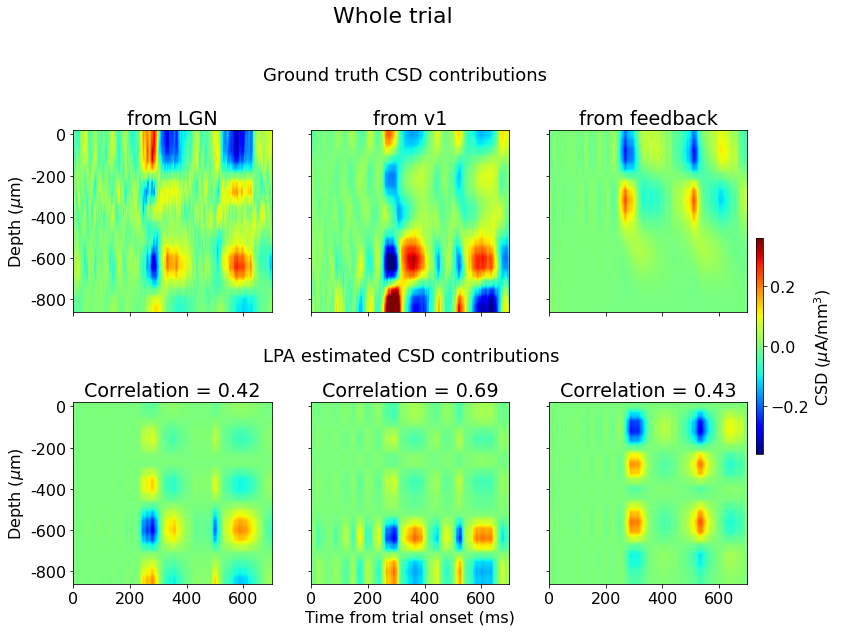

In [203]:
fig, axes = plt.subplots(nrows = 2, ncols = npop_guess+2, figsize = (6*(npop_guess+1),10), sharex = True, sharey = True)
    
tstim_onset = 200
scale_to_uA = 1E-3

for isim, sim_name in enumerate(csd_sims_gt_v1_summed.keys()):
    csd_sim = csd_sims_gt_v1_summed[sim_name]['trial_avg'][:nchan_lim,:]*scale_to_uA
    
    if 'LGN' not in sim_name:
        csd_sim = gaussian_filter(csd_sim, sigma = (1.4,0))
    
    icol = isim % 3

    ax = axes[0, icol]

    if icol == 0:
        cmap_range = np.abs(csd_sim).max()
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        ax.set_ylabel('Depth ($\mu$m)')
    
    im = ax.imshow(csd_sim, cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')
    
    ax.set_title('from '+sim_name)
    
    if isim == 0:
        #ax.set_yticks(yticks)
        #ax.set_yticklabels(ytick_labels)
        ax.set_ylabel('Depth ($\mu$m)')
        
    
            
    csd_lpa_pop_est = csd_lpa_pop_recon[istim, isim, :nchan_lim, :]*scale_to_uA
    
    ax = axes[1, icol]
    
    if icol == 0:
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        ax.set_ylabel('Depth ($\mu$m)')
    
    ax.imshow(csd_lpa_pop_est, cmap = 'jet', aspect = 'auto', vmin = -cmap_range, vmax = cmap_range)
    
    if isim == 1:
        ax.set_xlabel('Time from trial onset (ms)')
        
    corr = np.corrcoef(csd_sim.flatten(), csd_lpa_pop_est.flatten())[0,1]
    
    ax.set_title('Correlation = '+str(np.round(corr,2)))

        
    #ax.set_xticks(xticks)
    #ax.set_xticklabels(xticks_labels)
    
    #cb = fig.colorbar(im, ax = ax)
    
    #title_from_pop_name = sim_name.split('_')[-3]
    #ax.set_title('from '+title_from_pop_name)
    
#ax.set_xticks(np.arange(0,120,20))

plt.figtext(s = 'Whole trial', x = 0.4, y = 0.95, fontsize = 22)
    
plt.figtext(s = 'Ground truth CSD contributions', x = 0.32, y = 0.87, fontsize = 18)

plt.figtext(s = 'LPA estimated CSD contributions',  x = 0.32, y = 0.48, fontsize = 18)

fig.subplots_adjust(hspace = 0.5, left = 0.1, right = 0.88, bottom = 0.17, top = 0.8)
    
cbaxes = fig.add_axes([0.89,0.35,0.008, 0.3])
cb = fig.colorbar(im, ax = ax, cax = cbaxes)
cb.set_label('CSD ($\mu$A/mm$^3$)')
    
ax.set_xlim([0, csd_sim.shape[1]-1])

cb.set_label('CSD ($\mu$A/mm$^3$)')

fig_name = 'csd_pop_contribs_flash_common_scale_'+config_name+'_w_corr_whole_trial.png'

savepath = os.path.join(fig_dir, fir_rate_decomp_string)
    
if not os.path.exists(savepath):
    os.mkdir(savepath)

savepath = os.path.join(savepath, fig_name)

#fig.savefig(savepath, facecolor = 'w')
    

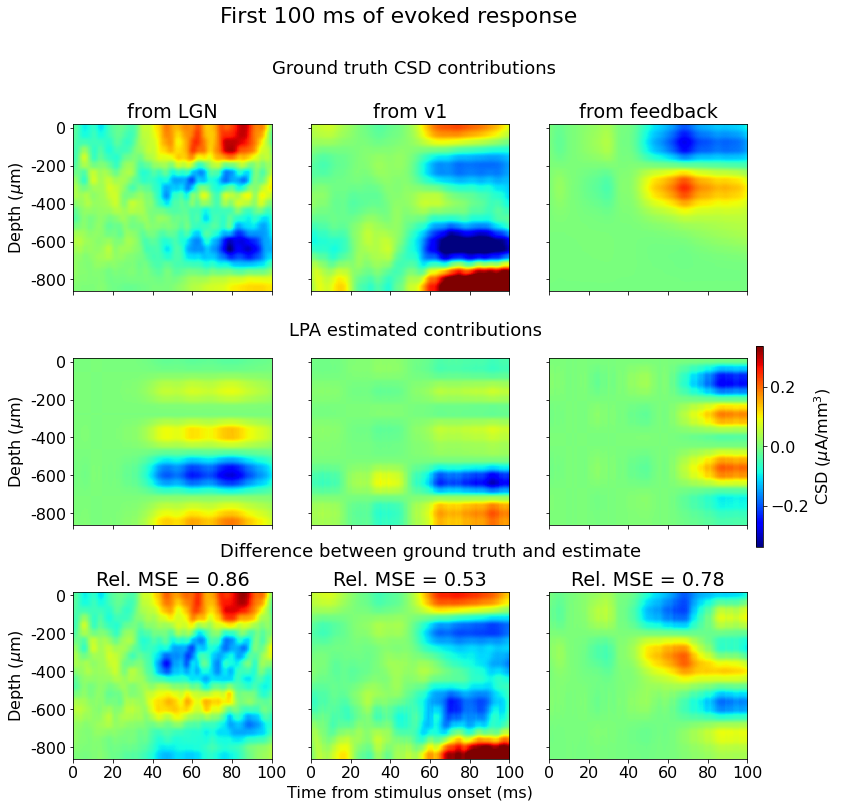

In [204]:
fig, axes = plt.subplots(nrows = 3, ncols = npop_guess+2, figsize = (6*(npop_guess+1),14), sharex = True, sharey = True)
    
fig.subplots_adjust(hspace = 0.4, left = 0.1, right = 0.88, bottom = 0.17, top = 0.8)

tstim_onset = 200
scale_to_uA = 1E-3

for isim, sim_name in enumerate(csd_sims_gt_v1_summed.keys()):
    csd_sim = csd_sims_gt_v1_summed[sim_name]['trial_avg'][:nchan_lim,tstim_onset:tstim_onset+101]*scale_to_uA
    
    if 'LGN' not in sim_name:
        csd_sim = gaussian_filter(csd_sim, sigma = (1.4,0))
    
    icol = isim % 3

    ax = axes[0, icol]
    if icol == 0:
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        ax.set_ylabel('Depth ($\mu$m)')

    if isim == 0:
        cmap_range = np.abs(csd_sim).max()
    
    im = ax.imshow(csd_sim, cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')
    
    ax.set_title('from '+sim_name)
            
    csd_lpa_pop_est = csd_lpa_pop_recon[istim, isim, :, tstim_onset:tstim_onset+101]*scale_to_uA
    
    ax = axes[1, icol]
    
    if icol == 0:
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        ax.set_ylabel('Depth ($\mu$m)')
    
    ax.imshow(csd_lpa_pop_est, cmap = 'jet', aspect = 'auto', vmin = -cmap_range, vmax = cmap_range)
        
        
    diff_csd = csd_sim - csd_lpa_pop_est
    
    rel_MSE = (diff_csd**2).sum()/(csd_sim**2).sum()
    
    RMSE = np.sqrt(((diff_csd**2).sum()/len(diff_csd))/(csd_sim**2).sum())
    
    RRMSE = np.sqrt(((diff_csd**2).sum()/len(diff_csd)))/np.sqrt((csd_sim**2).sum()/len(diff_csd))
    
    corr = np.corrcoef(csd_sim.flatten(), csd_lpa_pop_est.flatten())[0,1]
    
    ax = axes[2, icol]
    
    if icol == 0:
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        ax.set_ylabel('Depth ($\mu$m)')
        
    if icol == 1:
        ax.set_xlabel('Time from stimulus onset (ms)')
    
    ax.imshow(diff_csd, cmap = 'jet', aspect = 'auto', vmin = -cmap_range, vmax = cmap_range)
    
    ax.set_title('Rel. MSE = '+str(np.round(rel_MSE,2)))
        
    #ax.set_xticks(xticks)
    #ax.set_xticklabels(xticks_labels)
    
ax.set_xticks(np.arange(0,120,20))
    
plt.figtext(s = 'First 100 ms of evoked response', x = 0.27, y = 0.9, fontsize = 22)
    
plt.figtext(s='Ground truth CSD contributions', x = 0.33, y = 0.85, fontsize = 18)
    
plt.figtext(s = 'LPA estimated contributions', x = 0.35, y = 0.59, fontsize = 18)

plt.figtext(s = 'Difference between ground truth and estimate', x = 0.27, y = 0.37, fontsize = 18)
    
cbaxes = fig.add_axes([0.89,0.38,0.008, 0.2])
cb = fig.colorbar(im, ax = ax, cax = cbaxes)
cb.set_label('CSD ($\mu$A/mm$^3$)')
    
ax.set_xlim([0, csd_sim.shape[1]-1])

cb.set_label('CSD ($\mu$A/mm$^3$)')

fig_name = 'csd_pop_contribs_flash_common_scale_'+config_name+'_w_rel_MSE.png'

savepath = os.path.join(fig_dir, fir_rate_decomp_string)
    
if not os.path.exists(savepath):
    os.mkdir(savepath)

savepath = os.path.join(savepath, fig_name)

fig.savefig(savepath, facecolor = 'w') 

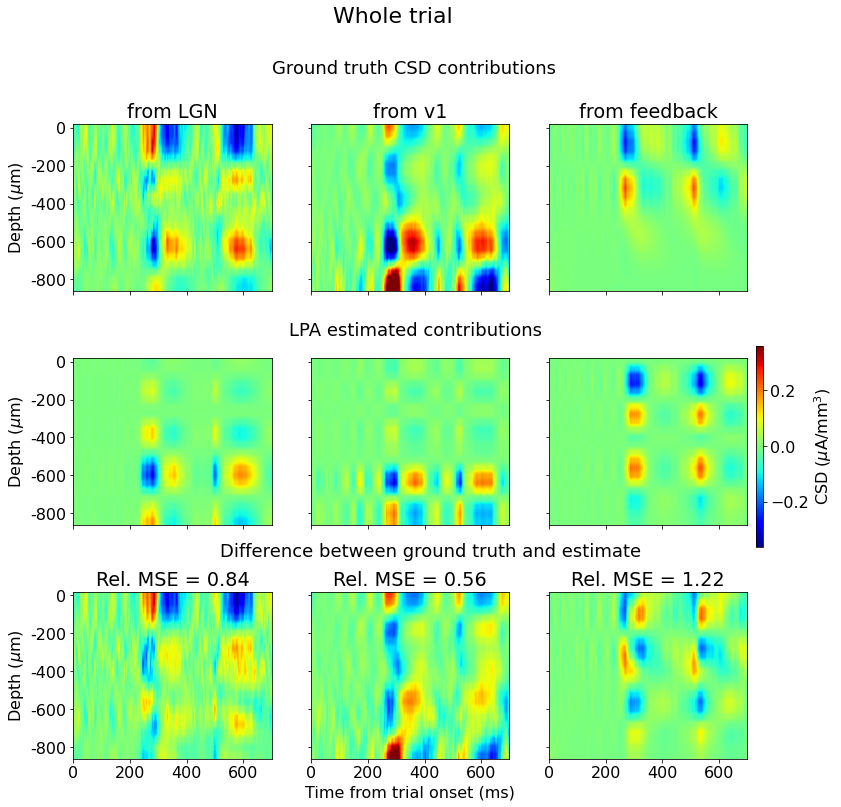

In [205]:
fig, axes = plt.subplots(nrows = 3, ncols = npop_guess+2, figsize = (6*(npop_guess+1),14), sharex = True, sharey = True)
    
fig.subplots_adjust(hspace = 0.4, left = 0.1, right = 0.88, bottom = 0.17, top = 0.8)

tstim_onset = 200
scale_to_uA = 1E-3

for isim, sim_name in enumerate(csd_sims_gt_v1_summed.keys()):
    csd_sim = csd_sims_gt_v1_summed[sim_name]['trial_avg'][:nchan_lim,:]*scale_to_uA
    
    if 'LGN' not in sim_name:
        csd_sim = gaussian_filter(csd_sim, sigma = (1.4,0))
    
    icol = isim % 3

    ax = axes[0, icol]
    if icol == 0:
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        ax.set_ylabel('Depth ($\mu$m)')

    if isim == 0:
        cmap_range = np.abs(csd_sim).max()
    
    im = ax.imshow(csd_sim, cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')
    
    ax.set_title('from '+sim_name)
            
    csd_lpa_pop_est = csd_lpa_pop_recon[istim, isim, :, :]*scale_to_uA
    
    ax = axes[1, icol]
    
    if icol == 0:
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        ax.set_ylabel('Depth ($\mu$m)')
    
    ax.imshow(csd_lpa_pop_est, cmap = 'jet', aspect = 'auto', vmin = -cmap_range, vmax = cmap_range)
        
        
    diff_csd = csd_sim - csd_lpa_pop_est
    
    rel_MSE = (diff_csd**2).sum()/(csd_sim**2).sum()
    
    RMSE = np.sqrt(((diff_csd**2).sum()/len(diff_csd))/(csd_sim**2).sum())
    
    RRMSE = np.sqrt(((diff_csd**2).sum()/len(diff_csd)))/np.sqrt((csd_sim**2).sum()/len(diff_csd))
    
    corr = np.corrcoef(csd_sim.flatten(), csd_lpa_pop_est.flatten())[0,1]
    
    ax = axes[2, icol]
    
    if icol == 0:
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        ax.set_ylabel('Depth ($\mu$m)')
        
    if icol == 1:
        ax.set_xlabel('Time from trial onset (ms)')
    
    ax.imshow(diff_csd, cmap = 'jet', aspect = 'auto', vmin = -cmap_range, vmax = cmap_range)
    
    ax.set_title('Rel. MSE = '+str(np.round(rel_MSE,2)))
        
    #ax.set_xticks(xticks)
    #ax.set_xticklabels(xticks_labels)
    
#ax.set_xticks(np.arange(0,120,20))

plt.figtext(s = 'Whole trial', x = 0.4, y = 0.9, fontsize = 22)
    
    
plt.figtext(s='Ground truth CSD contributions', x = 0.33, y = 0.85, fontsize = 18)
    
plt.figtext(s = 'LPA estimated contributions', x = 0.35, y = 0.59, fontsize = 18)

plt.figtext(s = 'Difference between ground truth and estimate', x = 0.27, y = 0.37, fontsize = 18)
    
cbaxes = fig.add_axes([0.89,0.38,0.008, 0.2])
cb = fig.colorbar(im, ax = ax, cax = cbaxes)
cb.set_label('CSD ($\mu$A/mm$^3$)')
    
ax.set_xlim([0, csd_sim.shape[1]-1])

cb.set_label('CSD ($\mu$A/mm$^3$)')

fig_name = 'csd_pop_contribs_flash_common_scale_'+config_name+'_w_rel_MSE_whole_trial.png'

savepath = os.path.join(fig_dir, fir_rate_decomp_string)
    
if not os.path.exists(savepath):
    os.mkdir(savepath)

savepath = os.path.join(savepath, fig_name)

#fig.savefig(savepath, facecolor = 'w') 

In [206]:
fig_dir

'Figures/for_Allen_call_Mar_30_2023'

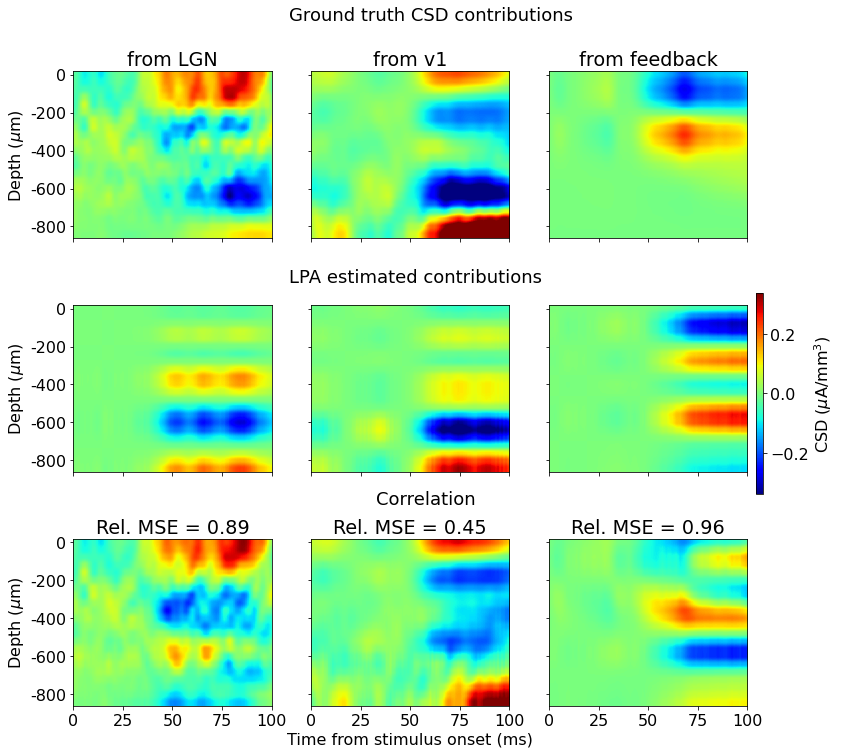

In [207]:
fig, axes = plt.subplots(nrows = 3, ncols = npop_guess+2, figsize = (6*(npop_guess+1),14), sharex = True, sharey = True)
    
fig.subplots_adjust(hspace = 0.4, left = 0.1, right = 0.88, bottom = 0.17, top = 0.8)

tstim_onset = 200
scale_to_uA = 1E-3

for isim, sim_name in enumerate(csd_sims_gt_v1_summed.keys()):
    csd_sim = csd_sims_gt_v1_summed[sim_name]['trial_avg'][:nchan_lim,tstim_onset:tstim_onset+101]*scale_to_uA
    
    if 'LGN' not in sim_name:
        csd_sim = gaussian_filter(csd_sim, sigma = (1.4,0))
    
    icol = isim % 3

    ax = axes[0, icol]
    if icol == 0:
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        ax.set_ylabel('Depth ($\mu$m)')

    if isim == 0:
        cmap_range = np.abs(csd_sim).max()
    
    im = ax.imshow(csd_sim, cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')
    
    ax.set_title('from '+sim_name)
    
            
    csd_lpa_pop_est = csd_lpa_pop_recon[istim, isim, :, tstim_onset:tstim_onset+101]*scale_to_uA
    
    ax = axes[1, icol]
    
    if icol == 0:
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        ax.set_ylabel('Depth ($\mu$m)')
    
    ax.imshow(csd_lpa_pop_est, cmap = 'jet', aspect = 'auto', vmin = -cmap_range, vmax = cmap_range)
        
        
    diff_csd = csd_sim - csd_lpa_pop_est
    
    rel_MSE = (diff_csd**2).sum()/(csd_sim**2).sum()
    
    RMSE = np.sqrt(((diff_csd**2).sum()/len(diff_csd))/(csd_sim**2).sum())
    
    RRMSE = np.sqrt(((diff_csd**2).sum()/len(diff_csd)))/np.sqrt((csd_sim**2).sum()/len(diff_csd))
    
    corr = np.corrcoef(csd_sim.flatten(), csd_lpa_pop_est.flatten())[0,1]
    
    ax = axes[2, icol]
    
    if icol == 0:
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        ax.set_ylabel('Depth ($\mu$m)')
        
    if icol == 1:
        ax.set_xlabel('Time from stimulus onset (ms)')
    
    ax.imshow(diff_csd, cmap = 'jet', aspect = 'auto', vmin = -cmap_range, vmax = cmap_range)
    
    ax.set_title('Rel. MSE = '+str(np.round(rel_MSE,2)))
        
    #ax.set_xticks(xticks)
    #ax.set_xticklabels(xticks_labels)
    
    
plt.figtext(s='Ground truth CSD contributions', x = 0.35, y = 0.85, fontsize = 18)
    
plt.figtext(s = 'LPA estimated contributions', x = 0.35, y = 0.59, fontsize = 18)

plt.figtext(s = 'Correlation', x = 0.45, y = 0.37, fontsize = 18)
    
cbaxes = fig.add_axes([0.89,0.38,0.008, 0.2])
cb = fig.colorbar(im, ax = ax, cax = cbaxes)
cb.set_label('CSD ($\mu$A/mm$^3$)')
    
ax.set_xlim([0, csd_sim.shape[1]-1])

cb.set_label('CSD ($\mu$A/mm$^3$)')

fig_name = 'csd_pop_contribs_flash_common_scale_'+config_name+'.png'

savepath = os.path.join(fig_dir, fig_name)

fig.savefig(savepath, facecolor = 'w')
    

In [208]:
tstim_onset

200

In [209]:
diff_csd = csd_sim - csd_lpa_pop_est

np.sqrt(((diff_csd**2).sum()/len(diff_csd))/(csd_sim**2).sum())*100

20.868266227375234

In [438]:
np.sqrt(((diff_csd/csd_sim)**2).sum()/len(csd_sim))

1329.3127441395447

In [439]:
csd_lpa_pop_est.flatten().shape

(2222,)

In [440]:
fig_dir

'Figures/for_Allen_call_Mar_30_2023'

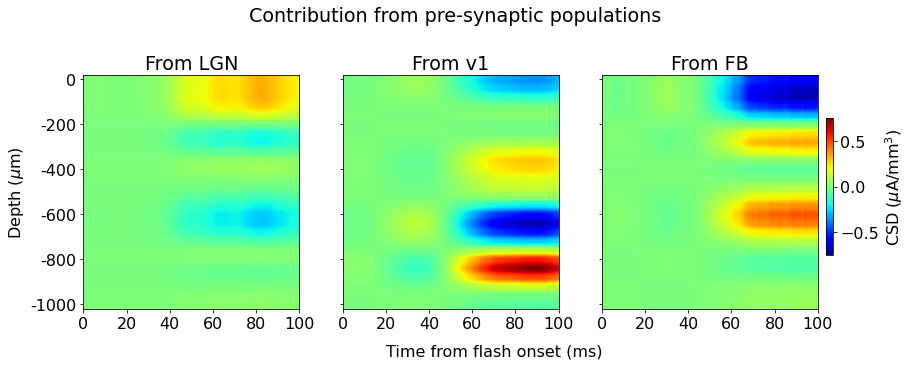

In [137]:
fig, axes = plt.subplots(ncols = csd_lpa_pop_recon.shape[1], figsize = (6*(npop_guess+1), 5), sharex = True, sharey = True)
fig.subplots_adjust(left = 0.07, right = 0.92, bottom = 0.15, top = 0.8)

scale_to_uA = 1E-3
cmap_range = np.abs(csd_lpa_pop_recon).max()*scale_to_uA
istim = 0
for ipop in range(csd_lpa_pop_recon.shape[1]):
    ax = axes[ipop]
    
    if ipop == 0:
        ax.set_ylabel('Depth ($\mu$m)')
        ax.set_yticks(np.arange(0,25+5,5))
        ax.set_yticklabels(-np.arange(0,1000+200,200))
        
    
        
    
    csd_lpa_pops_plot = csd_lpa_pop_recon[istim, ipop].copy()
    
    ax.set_title('From '+pop_names[ipop])
    
    for ichan in range(csd_lpa_pops_plot.shape[0]):
        csd_lpa_pops_plot[ichan] = csd_lpa_pops_plot[ichan]-np.mean(csd_lpa_pops_plot[ichan,:tstim_onset_sim])
    
    "im = ax.imshow(csd_lpa_pops_plot[:,tstim_onset_sim:tstim_onset_sim+101]*scale_to_mA, cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')"
    im = ax.imshow(csd_lpa_pops_plot[:,tstim_onset_sim:tstim_onset_sim+101]*scale_to_mA, cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')
    
ax.set_xticks(np.arange(0,100+20,20))
ax.set_xticklabels(np.arange(0,100+20,20))
ax.set_xlim([0,100])
plt.figtext(s = 'Time from flash onset (ms)', x = 0.42, y = 0.02)

cbaxes = fig.add_axes([0.93,0.30,0.008, 0.38])
cb = fig.colorbar(im, ax = ax, cax = cbaxes)
cb.set_label('CSD ($\mu$A/mm$^3$)')

fig.suptitle('Contribution from pre-synaptic populations', y = 0.99)

fig_name = 'csd_pre-syn_pop_contributions.png'
savepath = os.path.join(fig_dir, baseline_string, str(npop_guess)+'pops', lgn_string, fir_rate_decomp_string, fig_name)
#fig.savefig(savepath, facecolor = 'w')

In [88]:
fig, axes = plt.subplots(ncols = csd_lpa_pop_recon.shape[1], figsize = (6*npop_guess+1, 5), sharex = True, sharey = True)
fig.subplots_adjust(left = 0.07, right = 0.92, bottom = 0.15, top = 0.8)

scale_to_uA = 1E-3
cmap_range = np.abs(csd_lpa_pop_recon).max()/3*scale_to_uA
istim = 0
for ipop in range(csd_lpa_pop_recon.shape[1]):
    ax = axes[ipop]
    
    if ipop == 0:
        ax.set_ylabel('Depth ($\mu$m)')
        ax.set_yticks(np.arange(0,25+5,5))
        ax.set_yticklabels(-np.arange(0,1000+200,200))
        
    
        
    
    csd_lpa_pops_plot = csd_lpa_pop_recon[istim, ipop].copy()
    
    ax.set_title('From '+pop_names[ipop])
    
    for ichan in range(csd_lpa_pops_plot.shape[0]):
        csd_lpa_pops_plot[ichan] = csd_lpa_pops_plot[ichan]-np.mean(csd_lpa_pops_plot[ichan,:tstim_onset_sim])
    
    "im = ax.imshow(csd_lpa_pops_plot[:,tstim_onset_sim:tstim_onset_sim+101]*scale_to_mA, cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')"
    im = ax.imshow(csd_lpa_pops_plot[:,tstim_onset_sim:tstim_onset_sim+101]*scale_to_mA, cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')
    
ax.set_xticks(np.arange(0,100+20,20))
ax.set_xticklabels(np.arange(0,100+20,20))
ax.set_xlim([0,100])
plt.figtext(s = 'Time from flash onset (ms)', x = 0.42, y = 0.02)

cbaxes = fig.add_axes([0.93,0.30,0.008, 0.38])
cb = fig.colorbar(im, ax = ax, cax = cbaxes)
cb.set_label('CSD ($\mu$A/mm$^3$)')

fig.suptitle('Contribution from pre-synaptic populations', y = 0.99)

fig_name = 'csd_pre-syn_pop_contributions.png'
savepath = os.path.join(fig_dir, baseline_string, str(npop_guess)+'pops', lgn_string, fir_rate_decomp_string, fig_name)
#fig.savefig(savepath, facecolor = 'w')

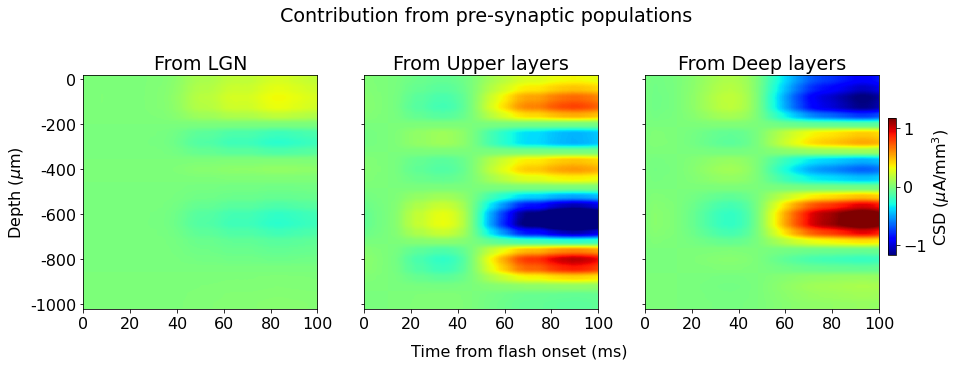

In [90]:
fig, axes = plt.subplots(ncols = csd_lpa_pop_recon.shape[1], figsize = (6*npop_guess+1, 5), sharex = True, sharey = True)
fig.subplots_adjust(left = 0.07, right = 0.92, bottom = 0.15, top = 0.8)

scale_to_uA = 1E-3
cmap_range = np.abs(csd_lpa_pop_recon).max()/2*scale_to_uA
istim = 0
for ipop in range(csd_lpa_pop_recon.shape[1]):
    ax = axes[ipop]
    
    if ipop == 0:
        ax.set_ylabel('Depth ($\mu$m)')
        ax.set_yticks(np.arange(0,25+5,5))
        ax.set_yticklabels(-np.arange(0,1000+200,200))
        
    
        
    
    csd_lpa_pops_plot = csd_lpa_pop_recon[istim, ipop].copy()
    
    ax.set_title('From '+pop_names[ipop])
    
    for ichan in range(csd_lpa_pops_plot.shape[0]):
        csd_lpa_pops_plot[ichan] = csd_lpa_pops_plot[ichan]-np.mean(csd_lpa_pops_plot[ichan,:tstim_onset_sim])
    
    "im = ax.imshow(csd_lpa_pops_plot[:,tstim_onset_sim:tstim_onset_sim+101]*scale_to_mA, cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')"
    im = ax.imshow(csd_lpa_pops_plot[:,tstim_onset_sim:tstim_onset_sim+101]*scale_to_mA, cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')
    
ax.set_xticks(np.arange(0,100+20,20))
ax.set_xticklabels(np.arange(0,100+20,20))
ax.set_xlim([0,100])
plt.figtext(s = 'Time from flash onset (ms)', x = 0.42, y = 0.02)

cbaxes = fig.add_axes([0.93,0.30,0.008, 0.38])
cb = fig.colorbar(im, ax = ax, cax = cbaxes)
cb.set_label('CSD ($\mu$A/mm$^3$)')

fig.suptitle('Contribution from pre-synaptic populations', y = 0.99)

fig_name = 'csd_pre-syn_pop_contributions.png'
savepath = os.path.join(fig_dir, baseline_string, str(npop_guess)+'pops', lgn_string, fir_rate_decomp_string, fig_name)
#fig.savefig(savepath, facecolor = 'w')

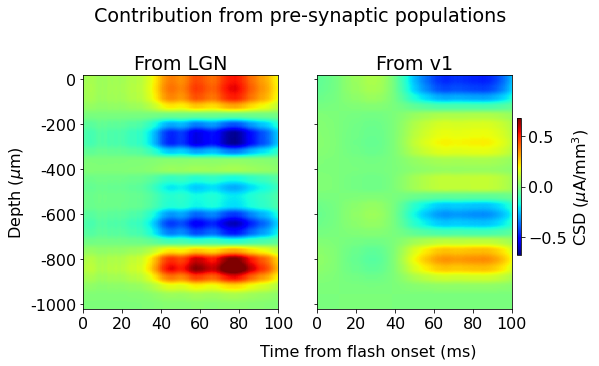

In [140]:
fig, axes = plt.subplots(ncols = csd_lpa_pop_recon.shape[1], figsize = (6*npop_guess+1, 5), sharex = True, sharey = True)
fig.subplots_adjust(left = 0.07, right = 0.92, bottom = 0.15, top = 0.8)

scale_to_uA = 1E-3
cmap_range = np.abs(csd_lpa_pop_recon).max()/4*scale_to_uA
istim = 0
for ipop in range(csd_lpa_pop_recon.shape[1]):
    ax = axes[ipop]
    
    if ipop == 0:
        ax.set_ylabel('Depth ($\mu$m)')
        ax.set_yticks(np.arange(0,25+5,5))
        ax.set_yticklabels(-np.arange(0,1000+200,200))
        
    
        
    
    csd_lpa_pops_plot = csd_lpa_pop_recon[istim, ipop].copy()
    
    ax.set_title('From '+pop_names[ipop])
    
    for ichan in range(csd_lpa_pops_plot.shape[0]):
        csd_lpa_pops_plot[ichan] = csd_lpa_pops_plot[ichan]-np.mean(csd_lpa_pops_plot[ichan,:tstim_onset_sim])
    
    "im = ax.imshow(csd_lpa_pops_plot[:,tstim_onset_sim:tstim_onset_sim+101]*scale_to_mA, cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')"
    im = ax.imshow(csd_lpa_pops_plot[:,tstim_onset_sim:tstim_onset_sim+101]*scale_to_mA, cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')
    
ax.set_xticks(np.arange(0,100+20,20))
ax.set_xticklabels(np.arange(0,100+20,20))
ax.set_xlim([0,100])
plt.figtext(s = 'Time from flash onset (ms)', x = 0.42, y = 0.02)

cbaxes = fig.add_axes([0.93,0.30,0.008, 0.38])
cb = fig.colorbar(im, ax = ax, cax = cbaxes)
cb.set_label('CSD ($\mu$A/mm$^3$)')

fig.suptitle('Contribution from pre-synaptic populations', y = 0.99)

fig_name = 'csd_pre-syn_pop_contributions.png'
savepath = os.path.join(fig_dir, baseline_string, str(npop_guess)+'pops', lgn_string, fir_rate_decomp_string, fig_name)
#fig.savefig(savepath, facecolor = 'w')

#### Save

In [250]:
baseline_string

'baseline_subtracted'

In [101]:
savepath = os.path.join('LPA_estimates', 'w_feedback', baseline_string, 'decomp_w_model_fir_rates', lgn_string, str(npop_guess)+'_pops', 'unconstrained', 
                       'opt_on_csd', 'opt_on_'+str(Cphi_lpa.shape[0])+'_stim', 'flash')
for ipath_part, path_part in enumerate(savepath.split('/')):
    if ipath_part == 0:
        path = path_part
    else:
        path = os.path.join(path, path_part)
    
    if not os.path.exists(path):
        os.mkdir(path)

In [102]:
filename = 'csd_pop_contribs.npy'

savepath = os.path.join('LPA_estimates', 'w_feedback', baseline_string, 'decomp_w_model_fir_rates', lgn_string, str(npop_guess)+'_pops', 'unconstrained', 
                       'opt_on_csd', 'opt_on_'+str(Cphi_lpa.shape[0])+'_stim', 'flash')
savepath = os.path.join(savepath, filename)

np.save(savepath, csd_lpa_pop_recon)

In [103]:
filename = 'csd_pop_contribs_dict.npy'

savepath = os.path.join('LPA_estimates', 'w_feedback', baseline_string, 'decomp_w_model_fir_rates', lgn_string, str(npop_guess)+'_pops', 'unconstrained', 
                       'opt_on_csd', 'opt_on_'+str(Cphi_lpa.shape[0])+'_stim', 'flash')

savepath = os.path.join(savepath, filename)

np.save(savepath, csd_lpa_dict)

In [370]:
csd_lpa_pops_dict

{'LGN': array([[ 2.39279867,  2.39279867,  1.14855724, ..., 45.52656286,
         46.33270747, 48.38537835],
        [ 2.54082668,  2.54082668,  1.21961154, ..., 48.34301641,
         49.19903232, 51.37868956],
        [ 2.63676825,  2.63676825,  1.26566405, ..., 50.16844788,
         51.05678693, 53.31874799],
        ...,
        [ 0.36794689,  0.36794689,  0.17661664, ...,  7.00073835,
          7.12470131,  7.44034586],
        [ 0.23516498,  0.23516498,  0.11288055, ...,  4.47436443,
          4.55359256,  4.75532968],
        [ 0.12665208,  0.12665208,  0.06079373, ...,  2.40974471,
          2.45241437,  2.56106331]]),
 'v1': array([[ -4.69738498,  -4.69738498,  -6.4259666 , ..., -47.79008276,
         -49.05325921, -50.13138409],
        [ -3.76096323,  -3.76096323,  -5.14495282, ..., -38.26314954,
         -39.27451228, -40.13771342],
        [ -0.05236997,  -0.05236997,  -0.0716415 , ...,  -0.53279972,
          -0.54688256,  -0.55890231],
        ...,
        [  1.52708172, 